# Scope:
The scope of this notebook is to create the classification model to classify the tumors in three classes (response, non-response and stable in tumor volume and/or elasticity). The model takes as input the tumor areas as Region of Interest (ROI).

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import regularizers
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import datetime, os, shutil
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import pandas as pd
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
from sklearn.model_selection import train_test_split
import random
plt.style.use("default")
import cv2
from keras import backend as K

In [2]:
from google.colab import drive

gdrive_path='/content/gdrive/MyDrive/DL_MechanoPredictor'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)

Mounted at /content/gdrive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


In [ ]:
my_datagen = ImageDataGenerator(rescale = 1./255)

my_set = my_datagen.flow_from_directory('./Elastography_images/classes',
#                                                 target_size = (224, 400),
                                              target_size = (300, 400),
                                                 class_mode = 'binary',
                                              batch_size=64,shuffle=False)

Found 1365 images belonging to 3 classes.


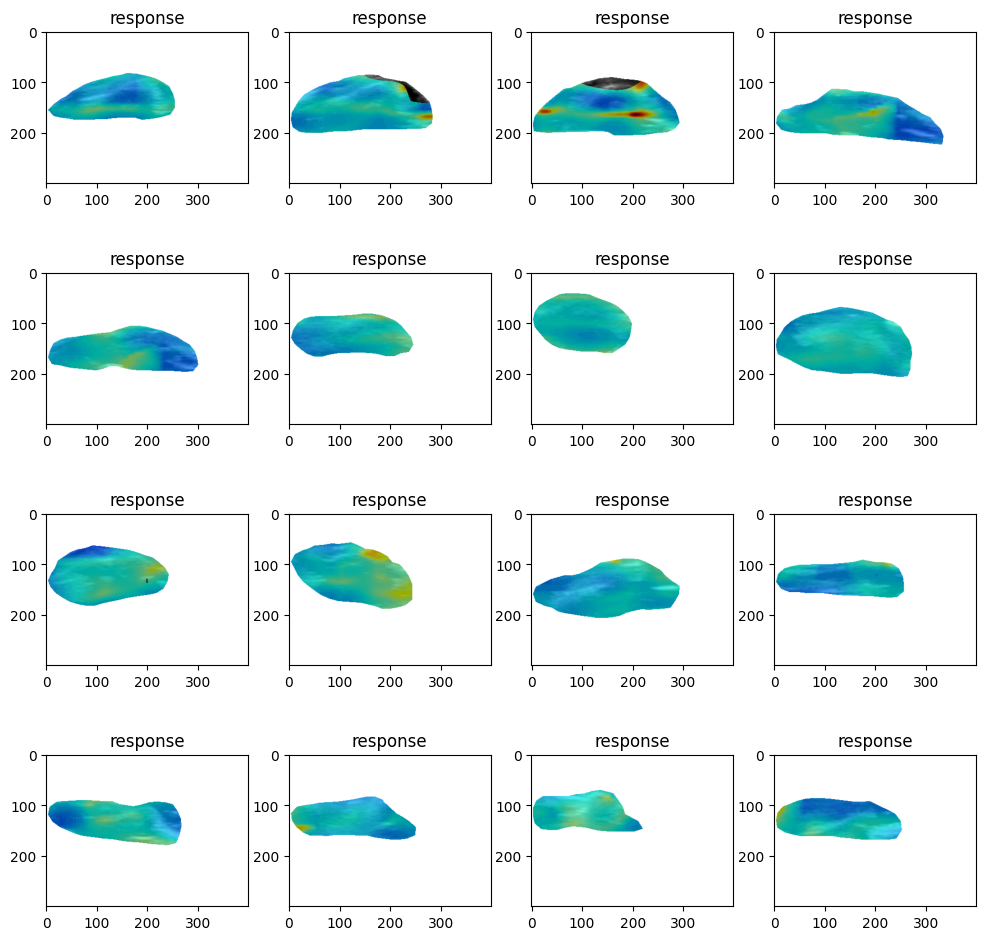

In [ ]:
#Let's see some non response images
with tf.device('/device:GPU:0'):
  j=4
  plt.figure(figsize =(12,12))

  class_names=['response','stable','non-response']

  for i in range(j**2):
      plt.subplot(j,j,i+1)
      imgplot = plt.imshow(my_set[0][0][i])
      plt.title(class_names[my_set[0][1][i].astype(int)])
      plt.axis("on")

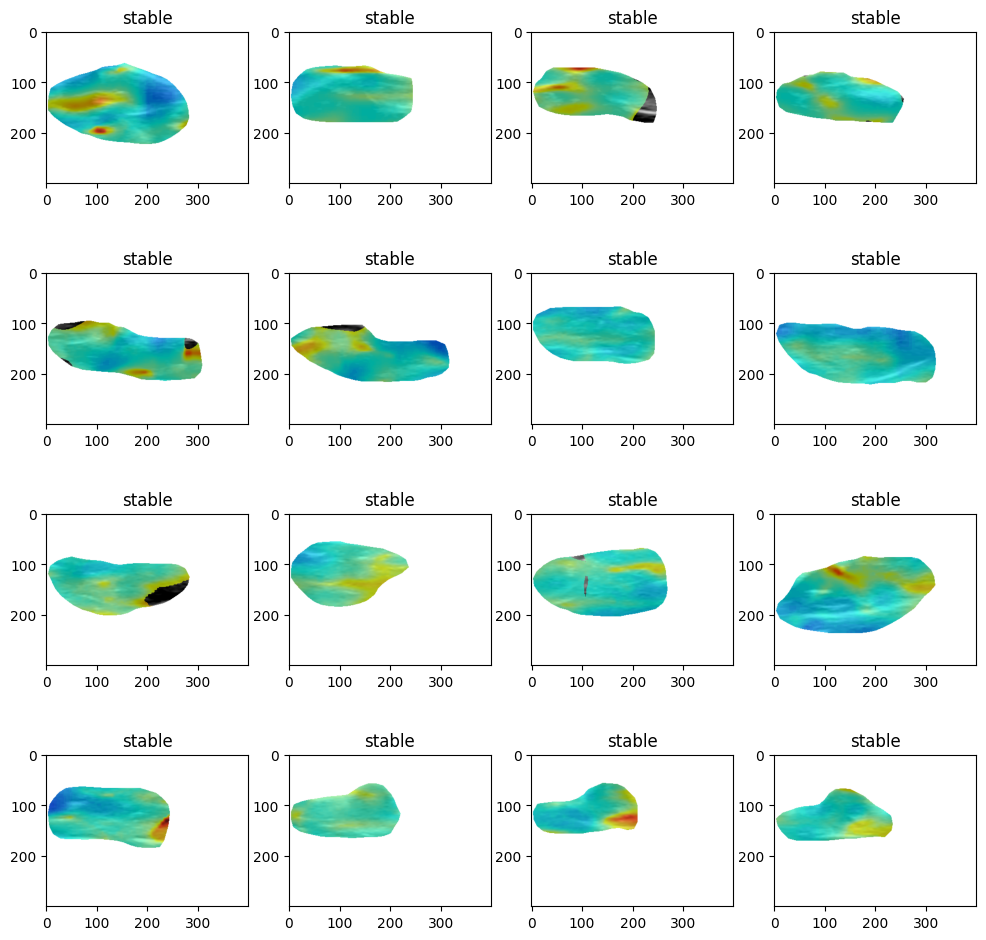

In [ ]:
#Let's see some stable images
with tf.device('/device:GPU:0'):
  j=4
  plt.figure(figsize =(12,12))

  class_names=['response','stable','non-response']

  for i in range(j**2):
      plt.subplot(j,j,i+1)
      imgplot = plt.imshow(my_set[10][0][i])
      plt.title(class_names[my_set[10][1][i].astype(int)])
      plt.axis("on")

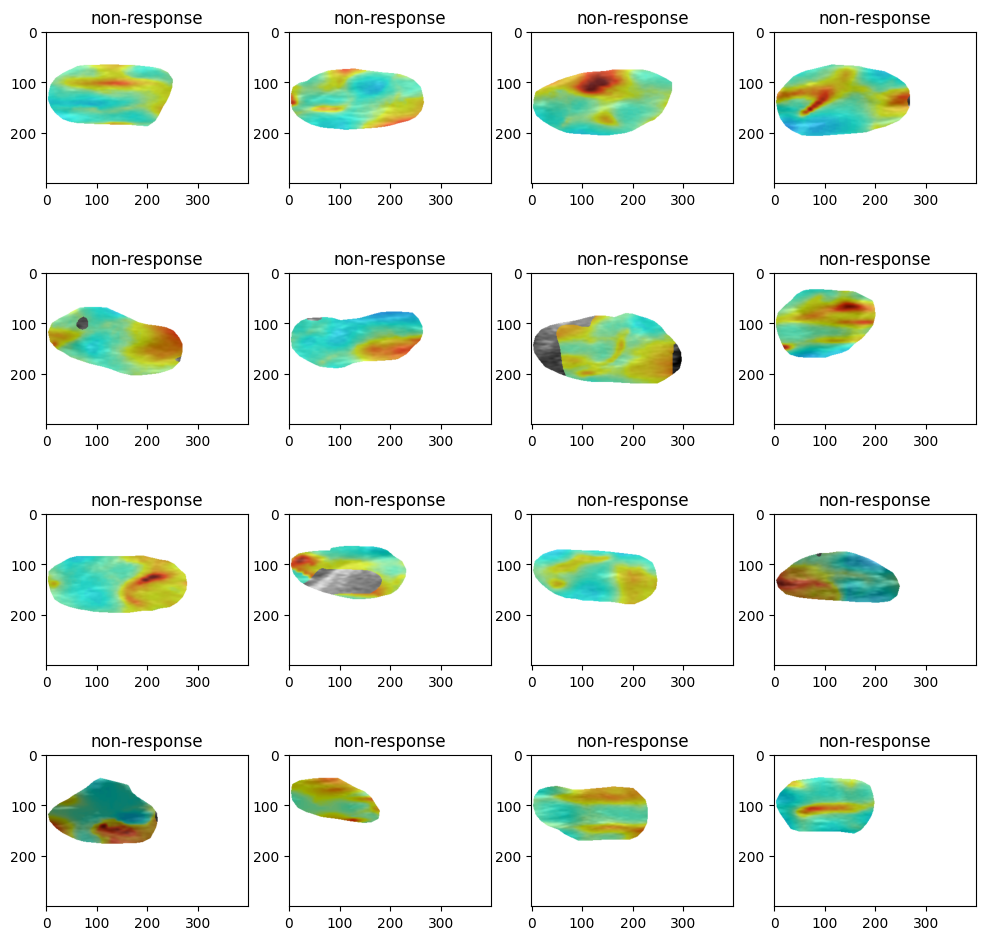

In [ ]:
#Let's see some no-response images
with tf.device('/device:GPU:0'):
  j=4
  plt.figure(figsize =(12,12))

  class_names=['response','stable','non-response']

  for i in range(j**2):
      plt.subplot(j,j,i+1)
      imgplot = plt.imshow(my_set[18][0][i])
      plt.title(class_names[my_set[18][1][i].astype(int)])
      plt.axis("on")

In [ ]:
my_datagen = ImageDataGenerator(rescale = 1./255)

my_set = my_datagen.flow_from_directory('./Elastography_images/classes',
                                              target_size = (60, 80),
                                              class_mode = 'binary',
                                              batch_size=1365,shuffle=False)

Found 1365 images belonging to 3 classes.


In [ ]:
with tf.device('/device:GPU:0'):
  x_tr=my_set[0][0]
  y_tr=my_set[0][1].astype(int)

print(f"We have {x_tr.shape[0]} total observations")

We have 1365 total observations


In [ ]:
np.unique(y_tr)

array([0, 1, 2])

In [ ]:
#USED IN CASE SHUFFLE IS FALSE WHILE IMPORTING THE DATA
x, y = shuffle(x_tr, y_tr)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

print(f"Training set has total {x_train.shape[0]} observations")
print(f"Validation set has total {x_val.shape[0]} observations")
print(f"Test set has total {x_test.shape[0]} observations \n \n")

print(f"Ratio of obervations with response label to total number of observations in the validation dataset is  {sum(y_val==0)/len(y_val)}")
print(f"Ratio of obervations with stable label to total number of observations in the validation dataset is  {sum(y_val==1)/len(y_val)}")
print(f"Ratio of obervations with non-response label to total number of observations in the validation dataset is  {sum(y_val==2)/len(y_val)} \n \n")

print(f"Ratio of obervations with response label to total number of observations in the test dataset is  {sum(y_test==0)/len(y_test)}")
print(f"Ratio of obervations with stable label to total number of observations in the test dataset is  {sum(y_test==1)/len(y_test)}")
print(f"Ratio of obervations with non-response label to total number of observations in the test dataset is  {sum(y_test==2)/len(y_test)} \n")

Training set has total 955 observations
Validation set has total 205 observations
Test set has total 205 observations 
 

Ratio of obervations with response label to total number of observations in the validation dataset is  0.33170731707317075
Ratio of obervations with stable label to total number of observations in the validation dataset is  0.33658536585365856
Ratio of obervations with non-response label to total number of observations in the validation dataset is  0.33170731707317075 
 

Ratio of obervations with response label to total number of observations in the test dataset is  0.36097560975609755
Ratio of obervations with stable label to total number of observations in the test dataset is  0.3024390243902439
Ratio of obervations with non-response label to total number of observations in the test dataset is  0.33658536585365856 



In [20]:
#save the train,validation,test numpy arrays to use the same data for model comparison.
# np.save('x_train_three_classes.npy', x_train)
# np.save('y_train_three_classes.npy', y_train)
# np.save('x_val_three_classes.npy', x_val)
# np.save('y_val_three_classes.npy', y_val)
# np.save('x_test_three_classes.npy', x_test)
# np.save('y_test_three_classes.npy', y_test)

#load the saved numpy arrays
x_train=np.load('x_train_three_classes.npy')
y_train=np.load('y_train_three_classes.npy')
x_val=np.load('x_val_three_classes.npy')
y_val=np.load('y_val_three_classes.npy')
x_test=np.load('x_test_three_classes.npy')
y_test=np.load('y_test_three_classes.npy')

In [4]:
#batch size
batch_size=32
#From numpy arrays to dataset
with tf.device('/device:GPU:0'):
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
  val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
  test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Classifcation Models

### CNN
1. CNN Model 1

In [ ]:
# Model
inputs = keras.Input(shape=(60, 80, 3))
x = layers.Conv2D(8, (7, 7), strides=1, padding='same',kernel_initializer='he_normal')(inputs)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None, padding="valid", data_format=None)(x)
x = layers.Conv2D(8, (5, 5), strides=1, padding='same',kernel_initializer='he_normal')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None,padding='valid', data_format=None)(x)
x = layers.Conv2D(8, (3, 3), strides=1, padding='same',kernel_initializer='he_normal')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None,padding='valid', data_format=None)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_CNN = keras.Model(inputs, outputs)
model_CNN.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 60, 80, 3)]       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 60, 80, 8)         1184      
                                                                 
 activation_49 (Activation)  (None, 60, 80, 8)         0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 30, 40, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 30, 40, 8)         1608      
                                                                 
 activation_50 (Activation)  (None, 30, 40, 8)         0         
                                                          

In [ ]:
epochs=400

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(0.001, epochs)


# Compile the model
sgd=keras.optimizers.SGD(learning_rate=0.001)

def lr_scheduler(epoch, lr):
    return cosine_decay(epoch)

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

model_CNN.compile(
    optimizer=sgd,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0,patience=200,verbose=0, mode="min",baseline=None,restore_best_weights=True,start_from_epoch=20,)

# Train the model using a dataset
with tf.device('/device:GPU:0'):
  history = model_CNN.fit(train_set, epochs=epochs,validation_data=val_set,callbacks=[lr_scheduler_callback,early_stop])

Epoch 1/400
30/30 [==============================] - 1s 9ms/step - loss: 1.0879 - accuracy: 0.3654 - val_loss: 1.0763 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 2/400
30/30 [==============================] - 0s 5ms/step - loss: 1.0722 - accuracy: 0.4115 - val_loss: 1.0690 - val_accuracy: 0.4244 - lr: 9.9998e-04
Epoch 3/400
30/30 [==============================] - 0s 5ms/step - loss: 1.0618 - accuracy: 0.4283 - val_loss: 1.0610 - val_accuracy: 0.4537 - lr: 9.9994e-04
Epoch 4/400
30/30 [==============================] - 0s 5ms/step - loss: 1.0496 - accuracy: 0.4534 - val_loss: 1.0511 - val_accuracy: 0.4634 - lr: 9.9986e-04
Epoch 5/400
30/30 [==============================] - 0s 5ms/step - loss: 1.0361 - accuracy: 0.4838 - val_loss: 1.0402 - val_accuracy: 0.4683 - lr: 9.9975e-04
Epoch 6/400
30/30 [==============================] - 0s 5ms/step - loss: 1.0219 - accuracy: 0.5141 - val_loss: 1.0290 - val_accuracy: 0.4927 - lr: 9.9961e-04
Epoch 7/400
30/30 [==============================] - 0s 

In [ ]:
loss, acc = model_CNN.evaluate(test_set)  # returns loss and metrics
y_test_prob=model_CNN.predict(test_set)

print("Loss on test set: %.2f" % loss)
print("Acc on test set: %.2f" % acc)

7/7 [==============================] - 0s 2ms/step
Loss on test set: 0.36
Acc on test set: 0.83


In [ ]:
#save or load the model
# model_CNN.save("model_simpleCNN_3classes")
model = keras.models.load_model('model_simpleCNN_3classes')

In [ ]:
np.save('model_cnn_threeclasses.npy',history.history)

In [ ]:
df=np.load('model_cnn_threeclasses.npy',allow_pickle=True)
df1=pd.DataFrame({'lr': df.item()['lr'],'loss': df.item()['loss'],'accuracy': df.item()['accuracy'],'val_loss': df.item()['val_loss'],'val_accuracy': df.item()['val_accuracy']})
print(df1.head())

      lr      loss  accuracy  val_loss  val_accuracy
0  0.001  1.087934  0.365445  1.076277      0.395122
1  0.001  1.072161  0.411518  1.068959      0.424390
2  0.001  1.061779  0.428272  1.060989      0.453659
3  0.001  1.049564  0.453403  1.051072      0.463415
4  0.001  1.036061  0.483770  1.040181      0.468293


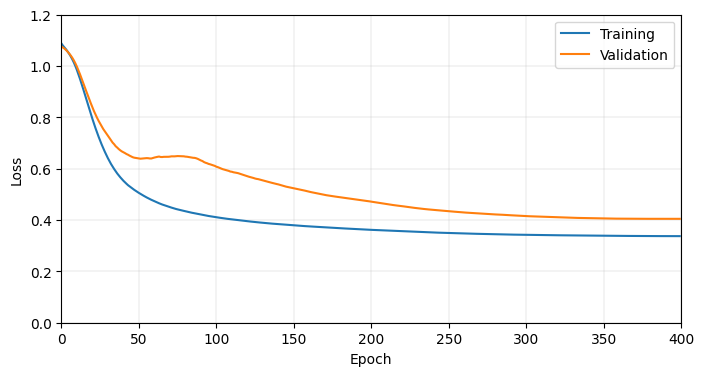

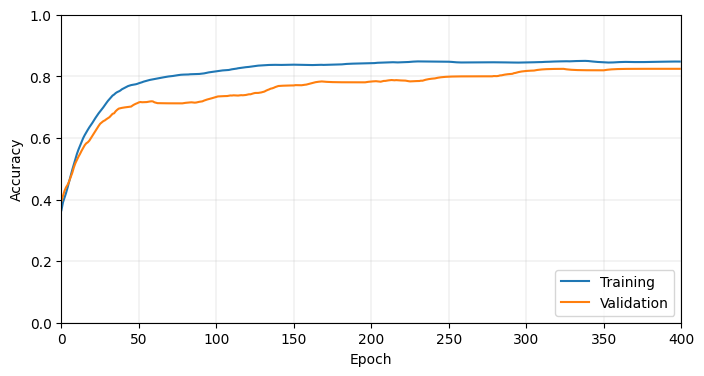

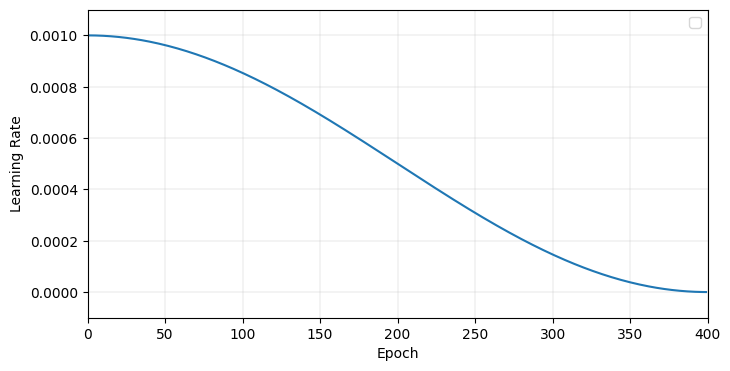

In [ ]:
plt.figure(figsize=(8,4))
ax = df1['loss'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_loss'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.grid(linewidth=0.2)
plt.ylim([0, 1.2])
plt.xlim([-0.1, 400])
plt.legend(loc='upper right')

plt.figure(figsize=(8,4))
ax = df1['accuracy'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_accuracy'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 400])
plt.legend(loc='lower right')

plt.figure(figsize=(8,4))
ax = df1['lr'].plot(label='')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.grid(linewidth=0.2)
plt.ylim([-0.0001,0.0011])
plt.xlim([-0.1, 400])
plt.legend(loc='upper right')

In [ ]:
y_pred=model_CNN.predict(test_set)
print(f"\nProbability per class for the first 5 images in the test set: \n {y_pred[0:5]} \n")
predictions = np.argmax(y_pred, axis=-1)
print(f"Predicted class for the first 5 images of the test set \n {predictions[0:5]}")

7/7 [==============================] - 0s 2ms/step

Probability per class for the first 5 images in the test set: 
 [[0.08789335 0.8946622  0.01744438]
 [0.16164927 0.81358695 0.02476375]
 [0.4280777  0.32278675 0.24913554]
 [0.21826218 0.7730673  0.00867056]
 [0.0024098  0.61327064 0.3843196 ]] 

Predicted class for the first 5 images of the test set 
 [1 1 0 1 1]


### More complex architecture with CNN and FC layers and by using data augmentations

In [ ]:
# a function to apply data augmentations on the training set
def apply_augmentations(x_train,y_train,horizontalflip=True,verticalflip=True,brightness=True,RandomCrops=True,RandomRotations=True,combine=True,size=100):

  if horizontalflip==True:
    x_train2=tf.image.flip_up_down(x_train[0:size])
    x_train=np.concatenate((x_train, x_train2), axis=0)
    y_train=np.concatenate((y_train, y_train[0:size]), axis=0)
  print(x_train.shape)
  print(y_train.shape)
  x_train, y_train = shuffle(x_train, y_train)

  if verticalflip==True:
    x_train2=tf.image.flip_left_right(x_train[0:size])
    x_train=np.concatenate((x_train, x_train2), axis=0)
    y_train=np.concatenate((y_train, y_train[0:size]), axis=0)
  print(x_train.shape)
  print(y_train.shape)
  x_train, y_train = shuffle(x_train, y_train)

  if brightness==True:
    size2=int(size/2)
    x_train2=tf.image.adjust_brightness(x_train[0:size2],0.25)
    x_train=np.concatenate((x_train, x_train2), axis=0)
    y_train=np.concatenate((y_train, y_train[0:size2]), axis=0)
  print(x_train.shape)
  print(y_train.shape)
  x_train, y_train = shuffle(x_train, y_train)
  x_train, y_train = shuffle(x_train, y_train)


  if RandomCrops == True:
    size2=int(size/2)
    train_datagen = ImageDataGenerator(zoom_range=0.2)
    crop=train_datagen.flow(x_train[0:size2],y_train[0:size2],batch_size=size2)
    x_train2=crop[0][0]
    y_train2=crop[0][1]
    x_train=np.concatenate((x_train, x_train2), axis=0)
    y_train=np.concatenate((y_train, y_train2), axis=0)
  print(x_train.shape)
  print(y_train.shape)
  x_train, y_train = shuffle(x_train, y_train)

  if RandomRotations == True:
    size2=int(size/2)
    train_datagen = ImageDataGenerator(rotation_range=60,fill_mode='constant',cval=1)
    rotate=train_datagen.flow(x_train[0:size2],y_train[0:size2],batch_size=size2)
    x_train2=rotate[0][0]
    y_train2=rotate[0][1]
    x_train=np.concatenate((x_train, x_train2), axis=0)
    y_train=np.concatenate((y_train, y_train2), axis=0)
  print(x_train.shape)
  print(y_train.shape)
  x_train, y_train = shuffle(x_train, y_train)

  if combine == True:
    size2=int(size/2)
    train_datagen = ImageDataGenerator(vertical_flip=False,horizontal_flip=True,shear_range = 0.2,zoom_range=0.2,fill_mode='constant',cval=1)
    comb=train_datagen.flow(x_train[0:size2],y_train[0:size2],batch_size=size2)
    x_train2=comb[0][0]
    y_train2=comb[0][1]
    x_train=np.concatenate((x_train, x_train2), axis=0)
    y_train=np.concatenate((y_train, y_train2), axis=0)


  return(x_train,y_train)

In [ ]:
print(f"Training set before augmentations: {x_train.shape[0]}")
x_train_augm,y_train_augm=apply_augmentations(x_train,y_train,size=600,horizontalflip=True,RandomCrops=True,verticalflip=True,combine=False,brightness=True,RandomRotations=True)
print(f"Training set after augmentations: {x_train_augm.shape[0]}")

Training set before augmentations: 955
(1555, 60, 80, 3)
(1555,)
(2155, 60, 80, 3)
(2155,)
(2455, 60, 80, 3)
(2455,)
(2755, 60, 80, 3)
(2755,)
(3055, 60, 80, 3)
(3055,)
Training set after augmentations: 3055


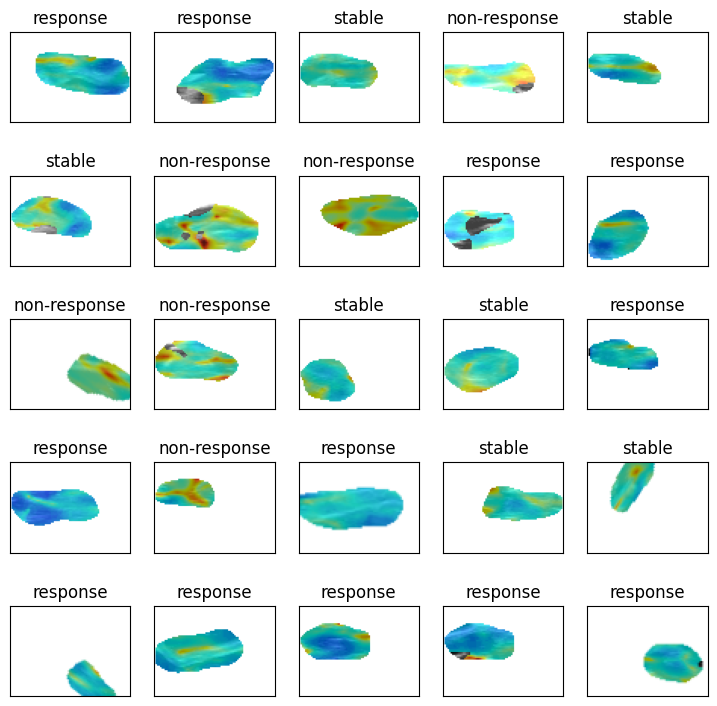

In [ ]:
with tf.device('/device:GPU:0'):
  j=5
  plt.figure(figsize =(9,9))

  class_names=['response','stable','non-response']

  for i in range(j**2):
      plt.subplot(j,j,i+1)
      imgplot = plt.imshow(x_train_augm[i])
      plt.title(class_names[y_train_augm[i].astype(int)])
      plt.axis("on")
      plt.xticks([]),plt.yticks([])
#  plt.savefig('augm.eps', format='eps',bbox_inches='tight',dpi=300)

In [ ]:
#batch size
batch_size=32
#From numpy arrays to dataset
train_set = tf.data.Dataset.from_tensor_slices((x_train_augm, y_train_augm)).batch(batch_size)
val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [ ]:
# Model
inputs = keras.Input(shape=(60, 80, 3))
x = layers.Conv2D(8, (7, 7), strides=1, padding='same',kernel_initializer='he_normal')(inputs)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None, padding="valid", data_format=None)(x)
x = layers.Dropout(0.15)(x)
x = layers.Conv2D(16, (5, 5), strides=1, padding='same',kernel_initializer='he_normal')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None,padding='valid', data_format=None)(x)
x = layers.Dropout(0.15)(x)
x = layers.Conv2D(16, (3, 3), strides=1, padding='same',kernel_initializer='he_normal')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None,padding='valid', data_format=None)(x)
x = layers.Dropout(0.15)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_CNN_FC_augm = keras.Model(inputs, outputs)
model_CNN_FC_augm.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 60, 80, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 60, 80, 8)         1184      
                                                                 
 activation_30 (Activation)  (None, 60, 80, 8)         0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 40, 8)        0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 30, 40, 8)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 30, 40, 16)        3216      
                                                          

In [ ]:
epochs=400

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(0.0035, epochs)


# Compile the model
sgd=keras.optimizers.SGD(learning_rate=0.0035)

def lr_scheduler(epoch, lr):
    return cosine_decay(epoch)

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

model_CNN_FC_augm.compile(
    optimizer=sgd,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0,patience=200,verbose=0, mode="min",baseline=None,restore_best_weights=True,start_from_epoch=20,)

# Train the model using a dataset
with tf.device('/device:GPU:0'):
  history = model_CNN_FC_augm.fit(train_set, epochs=epochs,validation_data=val_set,callbacks=[lr_scheduler_callback,early_stop])

Epoch 1/400
96/96 [==============================] - 2s 6ms/step - loss: 1.1777 - accuracy: 0.3493 - val_loss: 1.0989 - val_accuracy: 0.2829 - lr: 0.0035
Epoch 2/400
96/96 [==============================] - 0s 5ms/step - loss: 1.1054 - accuracy: 0.3473 - val_loss: 1.0988 - val_accuracy: 0.3317 - lr: 0.0035
Epoch 3/400
96/96 [==============================] - 0s 5ms/step - loss: 1.0996 - accuracy: 0.3810 - val_loss: 1.0977 - val_accuracy: 0.3317 - lr: 0.0035
Epoch 4/400
96/96 [==============================] - 0s 5ms/step - loss: 1.0965 - accuracy: 0.3712 - val_loss: 1.0980 - val_accuracy: 0.3317 - lr: 0.0035
Epoch 5/400
96/96 [==============================] - 0s 5ms/step - loss: 1.0926 - accuracy: 0.3810 - val_loss: 1.0958 - val_accuracy: 0.3317 - lr: 0.0035
Epoch 6/400
96/96 [==============================] - 0s 5ms/step - loss: 1.0901 - accuracy: 0.3895 - val_loss: 1.0931 - val_accuracy: 0.3317 - lr: 0.0035
Epoch 7/400
96/96 [==============================] - 0s 5ms/step - loss: 1.0

In [ ]:
loss, acc = model_CNN_FC_augm.evaluate(test_set)  # returns loss and metrics
y_test_prob=model_CNN_FC_augm.predict(test_set)

print("Loss on test set: %.2f" % loss)
print("Acc on test set: %.2f" % acc)

7/7 [==============================] - 0s 3ms/step
Loss on test set: 0.34
Acc on test set: 0.85


In [ ]:
#save or load the model
# model_CNN_FC_augm.save("model_CNN_FC_augm_3classes")
model_CNN_FC_augm = keras.models.load_model('model_CNN_FC_augm_3classes')

In [ ]:
np.save('model_cnn_fc_augm_threeclasses.npy',history.history)

In [ ]:
df=np.load('model_cnn_fc_augm_threeclasses.npy',allow_pickle=True)
df1=pd.DataFrame({'lr': df.item()['lr'],'loss': df.item()['loss'],'accuracy': df.item()['accuracy'],'val_loss': df.item()['val_loss'],'val_accuracy': df.item()['val_accuracy']})
print(df1.tail())

               lr      loss  accuracy  val_loss  val_accuracy
395  1.349226e-06  0.280413  0.883797  0.322984      0.853659
396  8.635670e-07  0.276981  0.879214  0.323003      0.853659
397  4.857630e-07  0.274624  0.880524  0.322997      0.853659
398  2.159178e-07  0.278718  0.879214  0.322979      0.853659
399  5.392731e-08  0.274959  0.882488  0.322980      0.853659


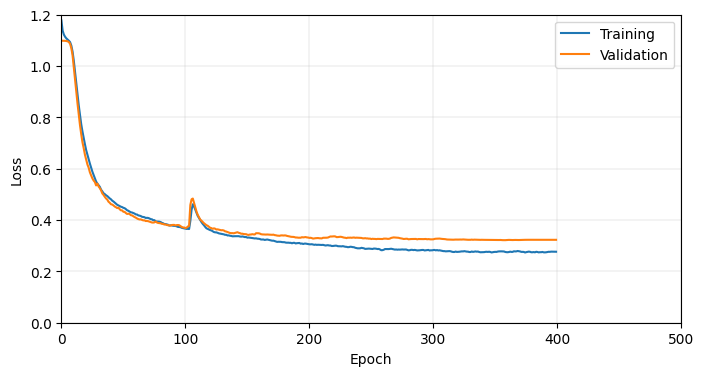

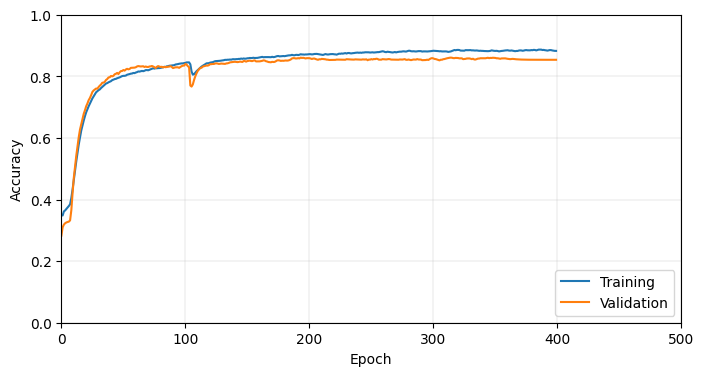

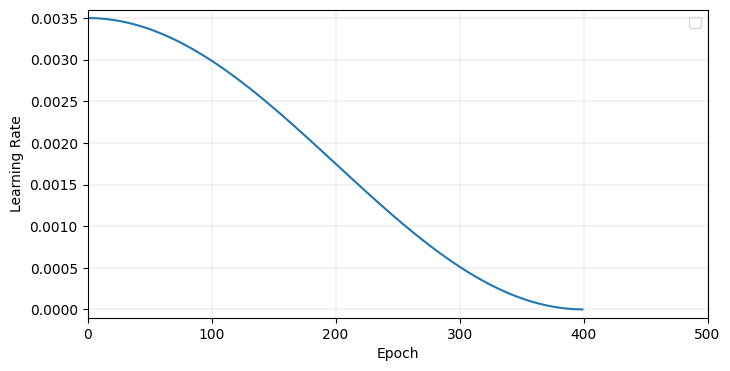

In [ ]:
plt.figure(figsize=(8,4))
ax = df1['loss'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_loss'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.grid(linewidth=0.2)
plt.ylim([0, 1.2])
plt.xlim([-0.1, 500])
plt.legend(loc='upper right')

plt.figure(figsize=(8,4))
ax = df1['accuracy'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_accuracy'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 500])
plt.legend(loc='lower right')

plt.figure(figsize=(8,4))
ax = df1['lr'].plot(label='')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.grid(linewidth=0.2)
plt.ylim([-0.0001,0.0036])
plt.xlim([-0.1, 500])
plt.legend(loc='upper right')

In [ ]:
y_pred=model_CNN_FC_augm.predict(test_set)
print(f"\nProbability per class for the first 5 images in the test set: \n {y_pred[0:5]} \n")
predictions = np.argmax(y_pred, axis=-1)
print(f"Predicted class for the first 5 images of the test set \n {predictions[0:5]}")

7/7 [==============================] - 7s 19ms/step

Probability per class for the first 5 images in the test set: 
 [[6.92209527e-02 9.02916491e-01 2.78625097e-02]
 [6.47391453e-02 9.12537038e-01 2.27238666e-02]
 [8.26334476e-01 1.69585198e-01 4.08036029e-03]
 [6.23082042e-01 3.73962849e-01 2.95509724e-03]
 [1.12673566e-04 3.90363306e-01 6.09524012e-01]] 

Predicted class for the first 5 images of the test set 
 [1 1 0 0 2]


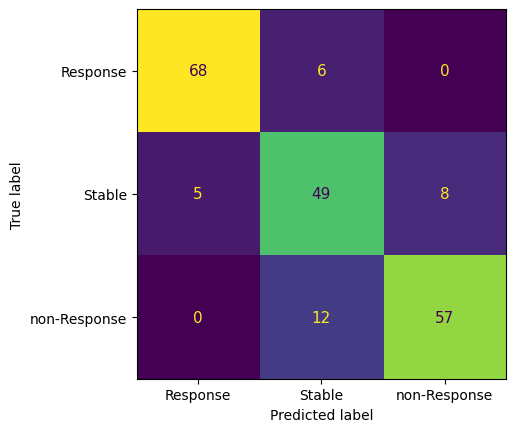

In [ ]:
cf_matrix = confusion_matrix(y_test,predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['Response','Stable','non-Response'])

cm_display.plot(colorbar=False, text_kw={'fontsize':11})
plt.show()

## Apply the post-hoc attention visualization technique called Grad-CAM
https://towardsdatascience.com/learn-to-pay-attention-trainable-visual-attention-in-cnns-87e2869f89f1

In [22]:
model_CNN_FC_augm = keras.models.load_model('model_CNN_FC_augm_3classes')

In [23]:
loss, acc = model_CNN_FC_augm.evaluate(test_set)  # returns loss and metrics
y_test_prob=model_CNN_FC_augm.predict(test_set)

print("Loss on test set: %.2f" % loss)
print("Acc on test set: %.2f" % acc)

7/7 [==============================] - 0s 4ms/step
Loss on test set: 0.34
Acc on test set: 0.85


In [ ]:
model_CNN_FC_augm.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 60, 80, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 60, 80, 8)         1184      
                                                                 
 activation_30 (Activation)  (None, 60, 80, 8)         0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 40, 8)        0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 30, 40, 8)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 30, 40, 16)        3216      
                                                          

In [24]:
#get the last convolutional layer
last_conv_layer = model_CNN_FC_augm.get_layer('conv2d_32')

In [25]:
argmax = np.argmax(y_test_prob[0])
output = model_CNN_FC_augm.output[:, argmax]

grad_model = tf.keras.models.Model([model_CNN_FC_augm.inputs], [last_conv_layer.output, model_CNN_FC_augm.output])
grad_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 60, 80, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 60, 80, 8)         1184      
                                                                 
 activation_30 (Activation)  (None, 60, 80, 8)         0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 40, 8)        0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 30, 40, 8)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 30, 40, 16)        3216      
                                                           

In [13]:
def generate_grad_cam(image):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
    cam = np.maximum(cam, 0)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))
    heatmap = np.uint8(255 * cam)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    output_image=cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)

    return output_image

In [26]:
im=[]
heat=[]
for i, (images, labels) in enumerate(train_set.take(20)):
    image = np.expand_dims(images, axis=0)
    image2=generate_grad_cam(image[0])
    im.append(image)
    heat.append(image2)

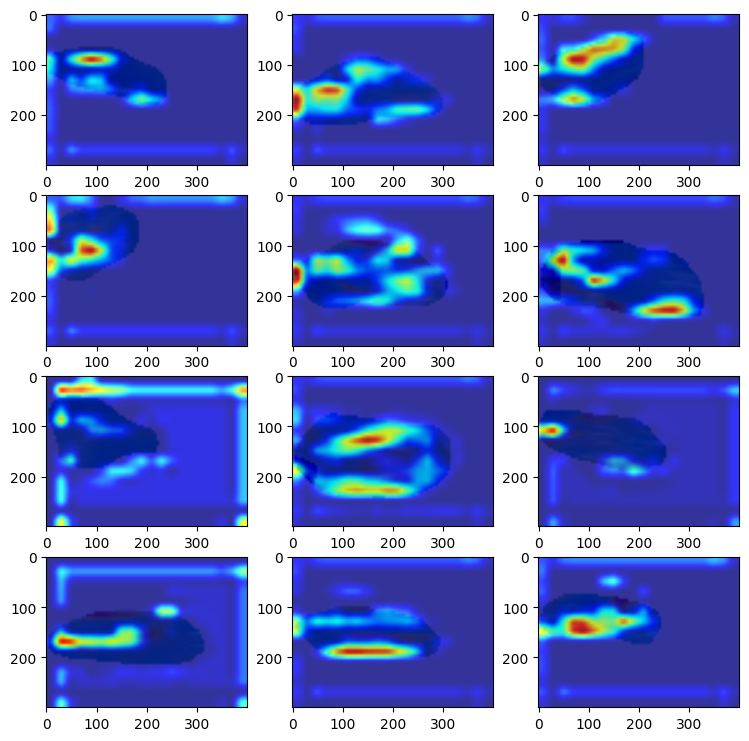

In [27]:
plt.figure(figsize =(9,9))
i=0

for j in range(12):
  plt.subplot(4,3,i+1)
  imgplot = plt.imshow(tf.image.resize(im[j][0][0],[300,400]))
  imgplot=plt.imshow(cv2.resize(heat[j], (400,300)),alpha=0.8)
  #plt.title(class_names[my_set[11][1][i].astype(int)])
  plt.axis("on")
  i+=1
  if i==16:
    break
# plt.savefig('post_hoc.eps', format='eps',bbox_inches='tight',dpi=450)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 60, 80, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 60, 80, 8)         1184      
                                                                 
 activation_30 (Activation)  (None, 60, 80, 8)         0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 40, 8)        0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 30, 40, 8)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 30, 40, 16)        3216      
                                                           

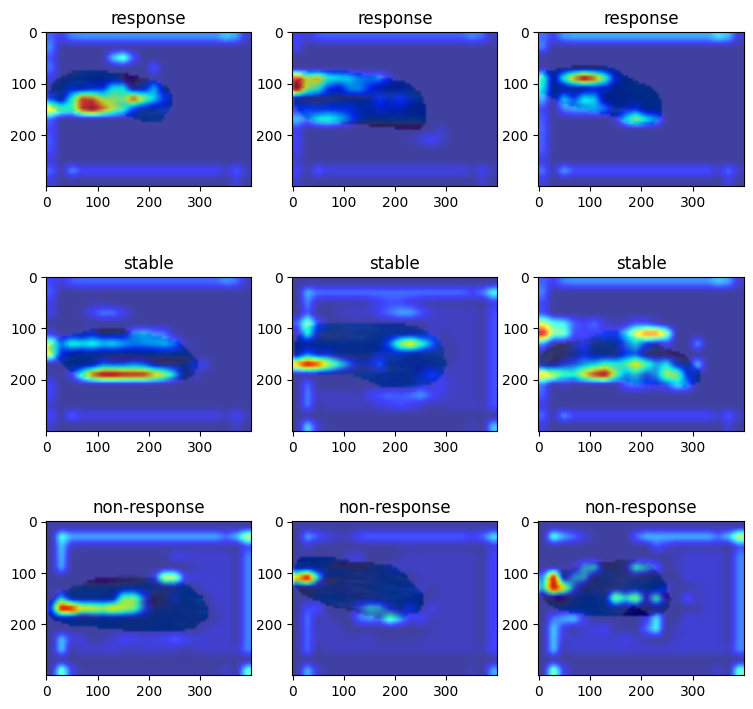

In [28]:
class_names=['response','stable','non-response']

grad_model = tf.keras.models.Model([model_CNN_FC_augm.inputs], [last_conv_layer.output, model_CNN_FC_augm.output])
grad_model.summary()


im=[]
heat=[]
lab=[]
for i, (images, labels) in enumerate(train_set.take(20)):
    image = np.expand_dims(images, axis=0)
    image2=generate_grad_cam(image[0])
    im.append(image)
    heat.append(image2)
    lab.append(labels)
plt.figure(figsize =(9,9))
i=0

for j in [11,12,0,10,13,19,9,8,16]:
  plt.subplot(3,3,i+1)
  imgplot = plt.imshow(tf.image.resize(im[j][0][0],[300,400]))
  imgplot=plt.imshow(cv2.resize(heat[j], (400,300)),alpha=0.75)
  plt.title(class_names[lab[j][0].numpy().astype(int)])
  plt.axis("on")
  i+=1
  if i==16:
    break
# plt.savefig('post_hoc_classes.eps', format='eps',bbox_inches='tight',dpi=450)

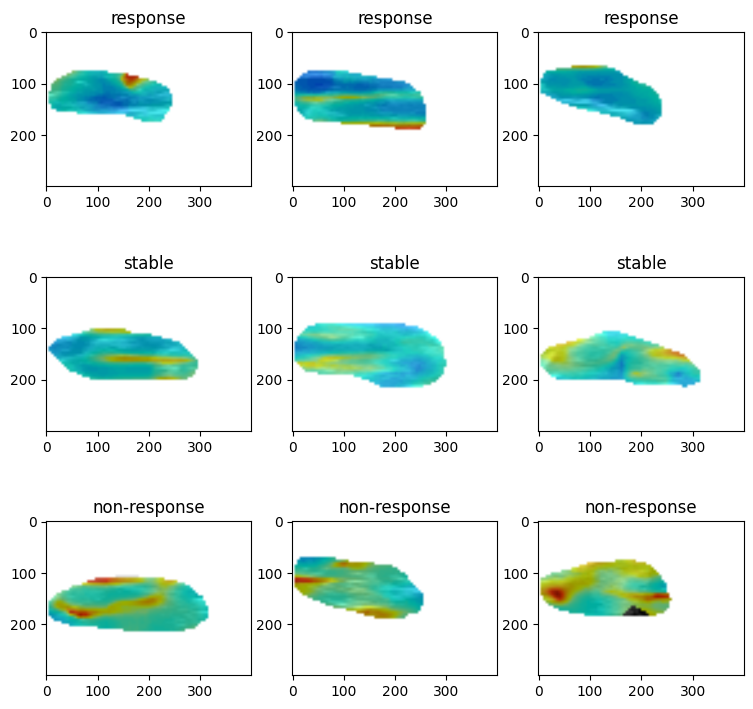

In [ ]:
plt.figure(figsize =(9,9))
i=0

for j in [11,12,0,10,13,19,9,8,16]:
  plt.subplot(3,3,i+1)
  imgplot = plt.imshow(tf.image.resize(im[j][0][0],[300,400]))
  plt.title(class_names[lab[j][0].numpy().astype(int)])
  i+=1
plt.savefig('post_hoc_input.eps', format='eps',bbox_inches='tight',dpi=450)

## Adding a trainable soft-attention mechanism to our best performing model
### Implementation of learn to pay attention

In [ ]:
class ParametrisedCompatibility(layers.Layer):

    def __init__(self, kernel_regularizer=None, **kwargs):
        super(ParametrisedCompatibility, self).__init__(**kwargs)
        self.regularizer = kernel_regularizer

    def build(self, input_shape):
        self.u = self.add_weight(name='u', shape=(input_shape[0][3], 1), initializer='uniform', regularizer=self.regularizer, trainable=True)
        super(ParametrisedCompatibility, self).build(input_shape)

    def call(self, x):  # add l and g. Dot the sum with u.
        return K.dot(K.map_fn(lambda lam: (lam[0]+lam[1]),elems=(x),dtype='float32'), self.u)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2])


# Model
regularizer = keras.regularizers.l2(0.0005)
inputs = keras.Input(shape=(60, 80, 3))
x = layers.Conv2D(16, (7, 7), strides=1, padding='same',kernel_initializer='he_normal', )(inputs)
x = layers.Conv2D(16, (5, 5), strides=1, padding='same',kernel_initializer='he_normal', )(x)
local12 = layers.Activation('relu')(x)
x = layers.Conv2D(16, (3, 3), strides=1, padding='same',kernel_initializer='he_normal', )(local12)
local1 = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None, padding="valid", data_format=None)(local1)
x = layers.Dropout(0.35)(x)
x = layers.Conv2D(32, (3, 3), strides=1, padding='same',kernel_initializer='he_normal', )(x)
local2 = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None,padding='valid', data_format=None)(local2)
x = layers.Dropout(0.35)(x)
x = layers.Conv2D(64, (3, 3), strides=1, padding='same',kernel_initializer='he_normal', )(x)
local3 = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=None,padding='valid', data_format=None)(local3)
x = layers.Dropout(0.35)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
g = layers.Dense(16, activation="relu")(x)

l1 = layers.Dense(16)(local1)  # batch*x*y*512
c1 = ParametrisedCompatibility(name='cpc1')([l1, g])  # batch*x*y
flatc1 = layers.Flatten(name='flatc1')(c1)  # batch*xy
a1 = layers.Activation('softmax', name='softmax1')(flatc1)  # batch*xy
reshaped1 = layers.Reshape((-1,16), name='reshape1')(l1)  # batch*xy*512.
g1 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g1')([a1, reshaped1])  # batch*512.

l2 = layers.Dense(16)(local2)  # batch*x*y*512
c2 = ParametrisedCompatibility(name='cpc2')([l2, g])  # batch*x*y
flatc2 = layers.Flatten(name='flatc2')(c2)  # batch*xy
a2 = layers.Activation('softmax', name='softmax2')(flatc2)  # batch*xy
reshaped2 = layers.Reshape((-1,16), name='reshape2')(l2)  # batch*xy*512.
g2 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g2')([a2, reshaped2])  # batch*512.

l3 = layers.Dense(16)(local12)  # batch*x*y*512
c3 = ParametrisedCompatibility(name='cpc3')([l3, g])  # batch*x*y
flatc3 = layers.Flatten(name='flatc3')(c3)  # batch*xy
a3 = layers.Activation('softmax', name='softmax3')(flatc3)  # batch*xy
reshaped3 = layers.Reshape((-1,16), name='reshape3')(l3)  # batch*xy*512.
g3 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g3')([a3, reshaped3])  # batch*512.

glist = [g3]
glist.append(g1)
predictedG = layers.Concatenate(axis=1, name='ConcatG')(glist)
x = layers.Dense(3, )(predictedG)
outputs = layers.Activation("softmax", name='concatsoftmaxout')(x)

model_att= keras.Model(inputs, outputs)
model_att.summary()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 60, 80, 3)]  0           []                               
                                                                                                  
 conv2d_93 (Conv2D)             (None, 60, 80, 8)    1184        ['input_19[0][0]']               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 60, 80, 8)    1608        ['conv2d_93[0][0]']              
                                                                                                  
 conv2d_95 (Conv2D)             (None, 60, 80, 16)   1168        ['conv2d_94[0][0]']              
                                                                                           

In [ ]:
epochs=400

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(0.0035, epochs)


# Compile the model
sgd=keras.optimizers.SGD(learning_rate=0.0035)

def lr_scheduler(epoch, lr):
    return cosine_decay(epoch)

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

model_att.compile(
    optimizer=sgd,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0,patience=100,verbose=0, mode="min",baseline=None,restore_best_weights=True,start_from_epoch=20,)

# Train the model using a dataset
with tf.device('/device:GPU:0'):
  history = model_att.fit(train_set, epochs=epochs,validation_data=val_set,callbacks=[lr_scheduler_callback,early_stop])

Epoch 1/400
96/96 [==============================] - 7s 46ms/step - loss: 1.0691 - accuracy: 0.4268 - val_loss: 1.0628 - val_accuracy: 0.3317 - lr: 0.0035
Epoch 2/400
96/96 [==============================] - 4s 38ms/step - loss: 1.0259 - accuracy: 0.4835 - val_loss: 1.0616 - val_accuracy: 0.3463 - lr: 0.0035
Epoch 3/400
96/96 [==============================] - 4s 40ms/step - loss: 0.8912 - accuracy: 0.5856 - val_loss: 0.7458 - val_accuracy: 0.6732 - lr: 0.0035
Epoch 4/400
96/96 [==============================] - 4s 39ms/step - loss: 0.7207 - accuracy: 0.6687 - val_loss: 0.6648 - val_accuracy: 0.7220 - lr: 0.0035
Epoch 5/400
96/96 [==============================] - 4s 39ms/step - loss: 0.6321 - accuracy: 0.7126 - val_loss: 0.5502 - val_accuracy: 0.7756 - lr: 0.0035
Epoch 6/400
96/96 [==============================] - 4s 41ms/step - loss: 0.5416 - accuracy: 0.7660 - val_loss: 0.4632 - val_accuracy: 0.7659 - lr: 0.0035
Epoch 7/400
96/96 [==============================] - 4s 39ms/step - lo

In [17]:
loss, acc = model_att.evaluate(test_set)  # returns loss and metrics
y_test_prob=model_att.predict(test_set)

print("Loss on test set: %.2f" % loss)
print("Acc on test set: %.2f" % acc)

7/7 [==============================] - 0s 22ms/step
Loss on test set: 0.31
Acc on test set: 0.87


In [6]:
#save or load the model
# model_att.save("model_att2")
model_att = keras.models.load_model('model_att2')

In [ ]:
np.save('model_attention2.npy',history.history)

In [7]:
def vis_att_weights(image,layer):
  attention_layer = model_att.get_layer(layer)
  attention_model = tf.keras.models.Model([model_att.input], [attention_layer.output,model_att.output])
  attention_weights = attention_model.predict(image)[0]
  return attention_weights

1/1 [==============================] - 0s 234ms/step


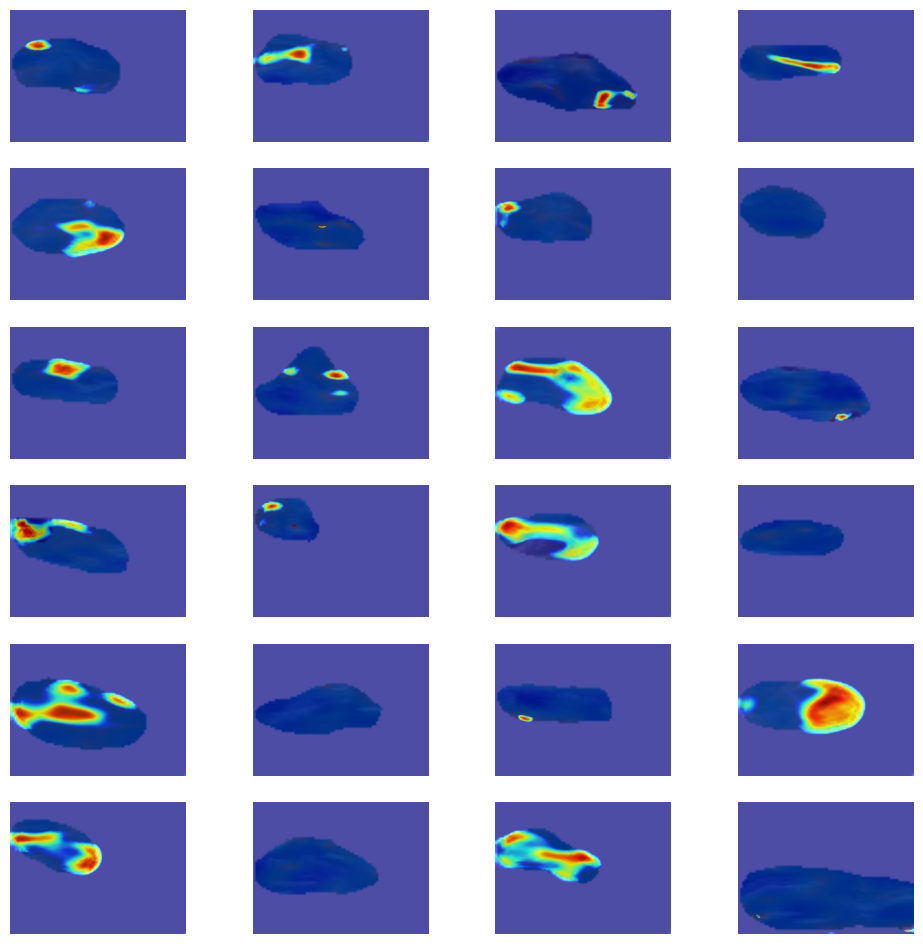

In [9]:
im=[]
att_weights=[]
for i, (images, labels) in enumerate(test_set.take(1)):
    image = np.expand_dims(images, axis=0)

att_w=vis_att_weights(image[0],'cpc3')
att_weights.append(att_w)

plt.figure(figsize =(12,12))
i=0
for j in range(24):
  plt.subplot(6,4,i+1)
  x=tf.image.resize(att_weights[0][j],[300,400])
  x = np.maximum(x, 0)
  if np.max(x) > 0:
    x /= np.max(x)
  x = np.uint8(255 * x)
  x = cv2.applyColorMap(x, cv2.COLORMAP_JET)
  x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
  imgplot = plt.imshow(tf.image.resize(image[0][j],[300,400]))
  imgplot = plt.imshow(x,cmap='jet',alpha=0.7)
  plt.axis("off")
  i+=1
  if i==24:
    break

1/1 [==============================] - 0s 383ms/step


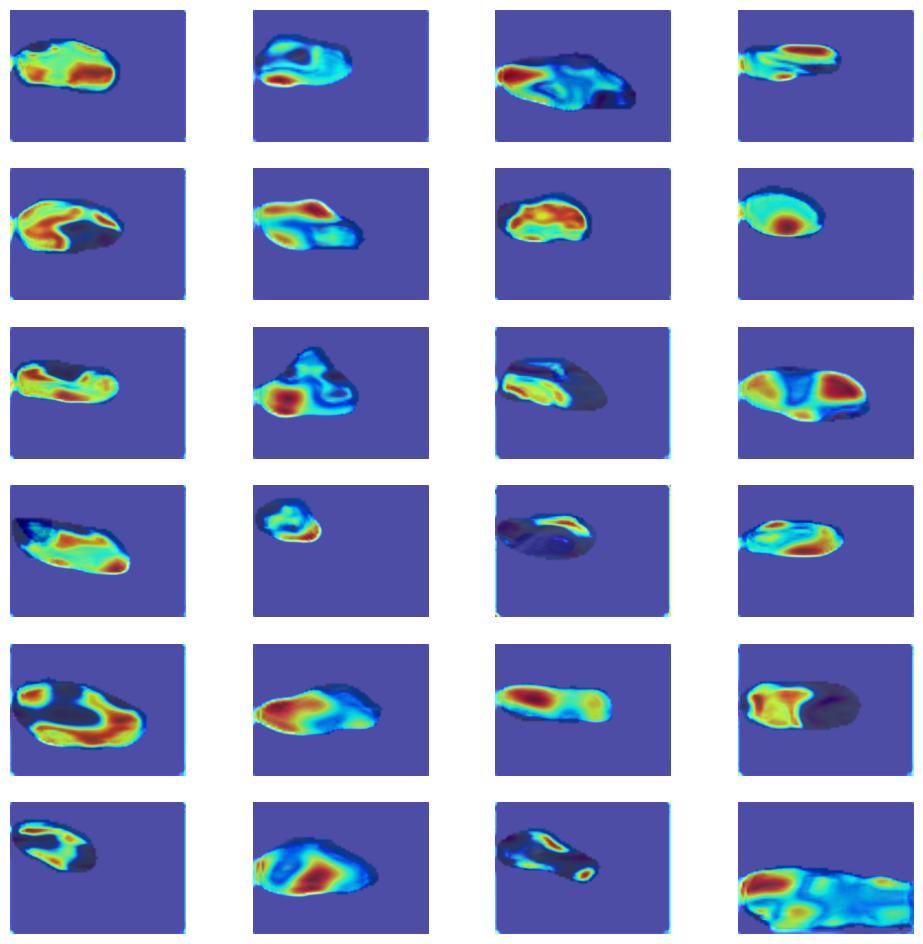

In [10]:
im=[]
att_weights=[]
for i, (images, labels) in enumerate(test_set.take(1)):
    image = np.expand_dims(images, axis=0)

att_w=vis_att_weights(image[0],'cpc1')
att_weights.append(att_w)

plt.figure(figsize =(12,12))
i=0
for j in range(24):
  plt.subplot(6,4,i+1)
  x=tf.image.resize(att_weights[0][j],[300,400])
  x = np.maximum(x, 0)
  if np.max(x) > 0:
    x /= np.max(x)

  x = np.uint8(255 * x)
  x = cv2.applyColorMap(x, cv2.COLORMAP_JET)
  x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
  imgplot = plt.imshow(tf.image.resize(image[0][j],[300,400]))
  imgplot = plt.imshow(x,cmap='jet',alpha=0.7)
  plt.axis("off")
  i+=1
  if i==24:
    break

In [11]:
last_conv_layer = model_att.get_layer('conv2d_132')

argmax = np.argmax(y_test_prob[0])
output = model_att.output[:, argmax]

grad_model = tf.keras.models.Model([model_att.inputs], [last_conv_layer.output, model_att.output])
grad_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 60, 80, 3)]  0           []                               
                                                                                                  
 conv2d_128 (Conv2D)            (None, 60, 80, 16)   2368        ['input_26[0][0]']               
                                                                                                  
 conv2d_129 (Conv2D)            (None, 60, 80, 16)   6416        ['conv2d_128[0][0]']             
                                                                                                  
 activation_90 (Activation)     (None, 60, 80, 16)   0           ['conv2d_129[0][0]']             
                                                                                            

In [14]:
im=[]
heat=[]
for i, (images, labels) in enumerate(train_set.take(20)):
    image = np.expand_dims(images, axis=0)
    image2=generate_grad_cam(image[0])
    im.append(image)
    heat.append(image2)

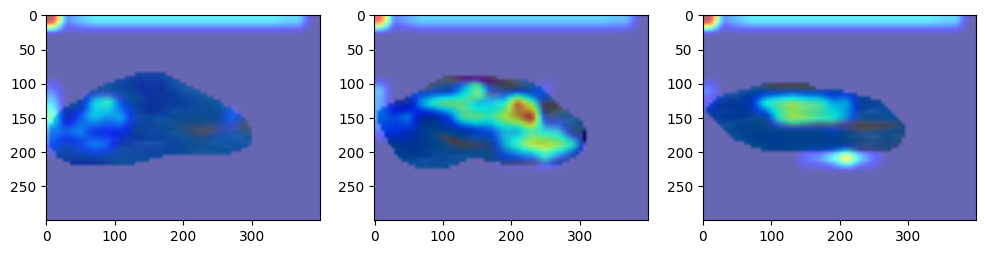

In [15]:
plt.figure(figsize =(12,12))
i=0

for j in [1,4,10]:
  plt.subplot(1,3,i+1)
  imgplot = plt.imshow(tf.image.resize(im[j][0][0],[300,400]),cmap='jet')
  imgplot=plt.imshow(cv2.resize(heat[j], (400,300)),alpha=0.6)
  #plt.title(class_names[my_set[11][1][i].astype(int)])
  plt.axis("on")
  i+=1
  if i==16:
    break

1/1 [==============================] - 1s 619ms/step


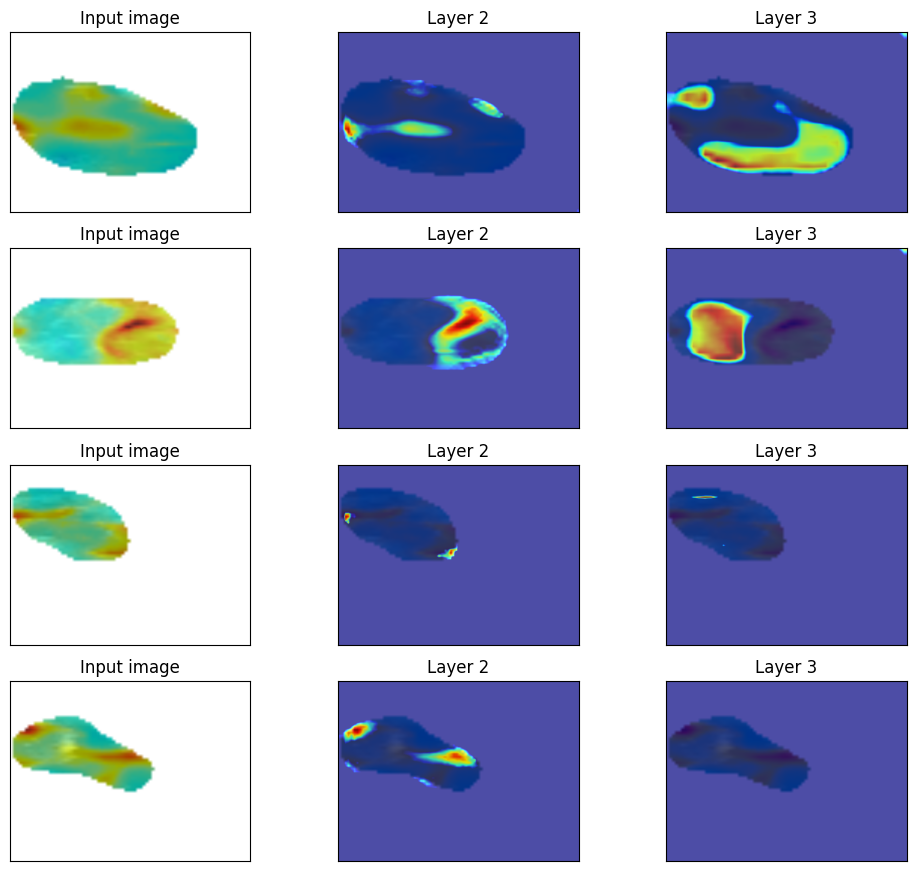

In [ ]:
im=[]
att_weights_layer1=[]
att_weights_layer2=[]
for i, (images, labels) in enumerate(test_set.take(1)):
    image = np.expand_dims(images, axis=0)

att_w=vis_att_weights(image[0],'cpc1')
att_weights_layer1.append(att_w)

att_w=vis_att_weights(image[0],'cpc2')
att_weights_layer2.append(att_w)

plt.figure(figsize =(12,22))
i=1
for j in range(15,23,1):
  x=tf.image.resize(att_weights_layer1[0][j],[300,400])
  x = np.maximum(x, 0)
  if np.max(x) > 0:
    x /= np.max(x)
    plt.subplot(8,3,i)
    i+=1
    imgplot = plt.imshow(tf.image.resize(image[0][j],[300,400]))
    plt.axis("on")
    plt.title("Input image")
    plt.tick_params(left = False, right = False , labelleft = False ,
                  labelbottom = False, bottom = False)
    plt.subplot(8,3,i)
    i+=1
    x=tf.image.resize(att_weights_layer1[0][j],[300,400])
    x = np.maximum(x, 0)
    if np.max(x) > 0:
      x /= np.max(x)

    x = np.uint8(255 * x)
    x = cv2.applyColorMap(x, cv2.COLORMAP_JET)
    x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(tf.image.resize(image[0][j],[300,400]))
    imgplot = plt.imshow(x,cmap='jet',alpha=0.7)
    plt.title("Layer 2")
    plt.axis("on")
    plt.tick_params(left = False, right = False , labelleft = False ,
                  labelbottom = False, bottom = False)

    plt.subplot(8,3,i)
    i+=1
    x=tf.image.resize(att_weights_layer2[0][j],[300,400])
    x = np.maximum(x, 0)
    if np.max(x) > 0:
      x /= np.max(x)

    x = np.uint8(255 * x)
    x = cv2.applyColorMap(x, cv2.COLORMAP_JET)
    x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(tf.image.resize(image[0][j],[300,400]))
    imgplot = plt.imshow(x,cmap='jet',alpha=0.7)
    plt.title("Layer 3")
    plt.axis("on")
    plt.tick_params(left = False, right = False , labelleft = False ,
                  labelbottom = False, bottom = False)

  if i==40:
    break

In [18]:
y_pred=model_att.predict(test_set)
print(f"\nProbability per class for the first 5 images in the test set: \n {y_pred[0:5]} \n")
predictions = np.argmax(y_pred, axis=-1)
print(f"Predicted class for the first 5 images of the test set \n {predictions[0:5]}")

7/7 [==============================] - 0s 34ms/step

Probability per class for the first 5 images in the test set: 
 [[6.7333408e-02 9.2133099e-01 1.1335591e-02]
 [2.8389204e-01 7.0738733e-01 8.7206010e-03]
 [7.4493545e-01 2.5054866e-01 4.5159375e-03]
 [4.7444311e-01 5.1992208e-01 5.6348532e-03]
 [2.5653653e-04 3.7293449e-01 6.2680894e-01]] 

Predicted class for the first 5 images of the test set 
 [1 1 0 1 2]


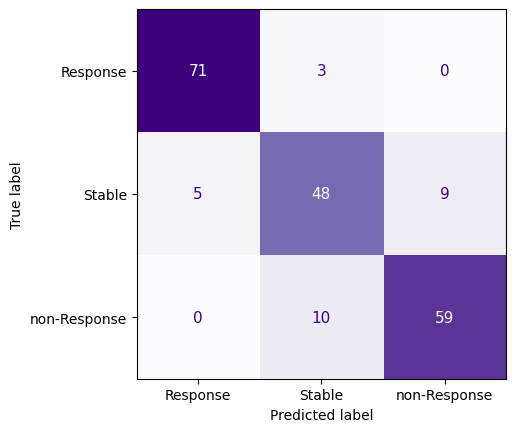

In [21]:
cf_matrix = confusion_matrix(y_test,predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['Response','Stable','non-Response'])

cm_display.plot(colorbar=False, text_kw={'fontsize':11},cmap='Purples')
plt.show()
# plt.savefig('conf.jpeg', edgecolor='black', dpi=400, facecolor='black', transparent=True)

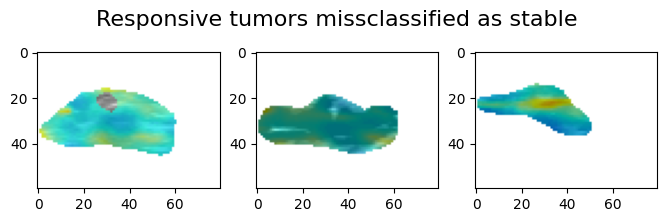

In [ ]:
with tf.device('/device:GPU:0'):
  plt.figure(figsize =(8,4))
  i=0

  for j in range(len(predictions)):
    if (predictions[j]==1) and (y_test[j]==0):
      plt.suptitle("Responsive tumors missclassified as stable", fontsize=16)
      plt.subplot(2,3,i+1)

      imgplot = plt.imshow(x_test[j])
      #plt.title(class_names[my_set[11][1][i].astype(int)])
      plt.axis("on")
      i+=1
      if i==6:
        break
# plt.savefig('respo_as_stable.eps', format='eps',bbox_inches='tight',dpi=600)

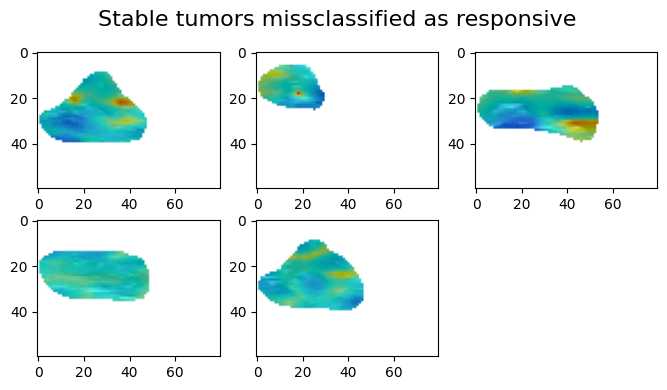

In [ ]:
with tf.device('/device:GPU:0'):
  plt.figure(figsize =(8,4))
  i=0

  for j in range(len(predictions)):
    if (predictions[j]==0) and (y_test[j]==1):
      plt.suptitle("Stable tumors missclassified as responsive", fontsize=16)
      plt.subplot(2,3,i+1)
      imgplot = plt.imshow(x_test[j])
      #plt.title(class_names[my_set[11][1][i].astype(int)])
      plt.axis("on")
      i+=1
      if i==6:
        break
# plt.savefig('stable_as_resp.eps', format='eps',bbox_inches='tight',dpi=600)

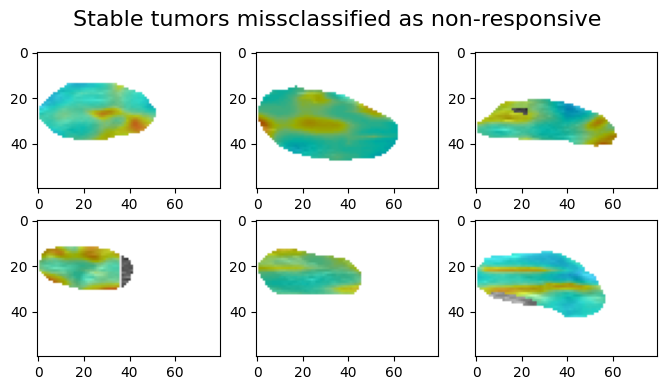

In [ ]:
with tf.device('/device:GPU:0'):
  plt.figure(figsize =(8,4))
  i=0

  for j in range(len(predictions)):
    if (predictions[j]==2) and (y_test[j]==1):
      plt.suptitle("Stable tumors missclassified as non-responsive", fontsize=16)
      plt.subplot(2,3,i+1)
      imgplot = plt.imshow(x_test[j])
      #plt.title(class_names[my_set[11][1][i].astype(int)])
      plt.axis("on")
      i+=1
      if i==6:
        break
# plt.savefig('stable_as_nonresp.eps', format='eps',bbox_inches='tight',dpi=600)

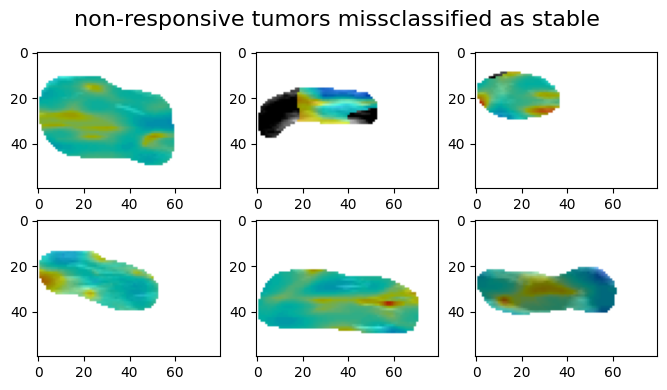

In [ ]:
with tf.device('/device:GPU:0'):
  plt.figure(figsize =(8,4))
  i=0

  for j in range(len(predictions)):
    if (predictions[j]==1) and (y_test[j]==2):
      plt.suptitle("non-responsive tumors missclassified as stable", fontsize=16)
      plt.subplot(2,3,i+1)
      imgplot = plt.imshow(x_test[j])
      #plt.title(class_names[my_set[11][1][i].astype(int)])
      plt.axis("on")
      i+=1
      if i==6:
        break
# plt.savefig('nonresp_as_stable.eps', format='eps',bbox_inches='tight',dpi=600)

## ROC curves

In [ ]:
y_score = model_att.predict(x_test)

7/7 [==============================] - 0s 14ms/step


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

def plot_roc(my_class):
  label_binarizer = LabelBinarizer().fit(y_train)
  y_onehot_test = label_binarizer.transform(y_test)
  y_onehot_test.shape  # (n_samples, n_classes)

  class_of_interest = my_class
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
  class_id

  x=RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
      color="darkorange",
  )

  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
  plt.legend()
  plt.show()

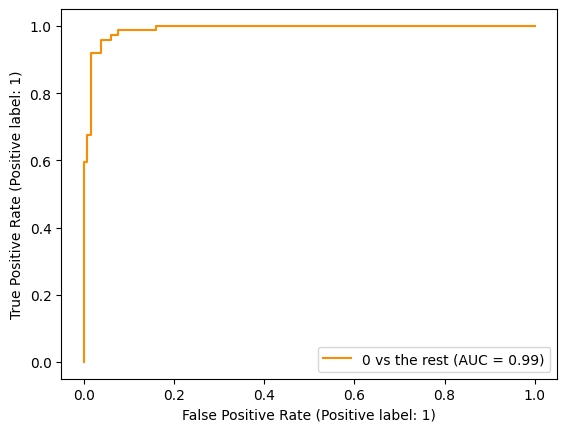

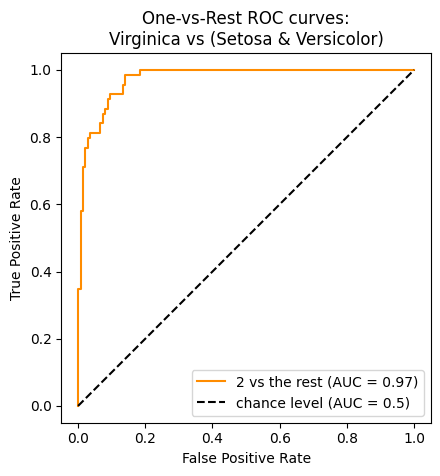

In [ ]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.97


In [ ]:
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.96


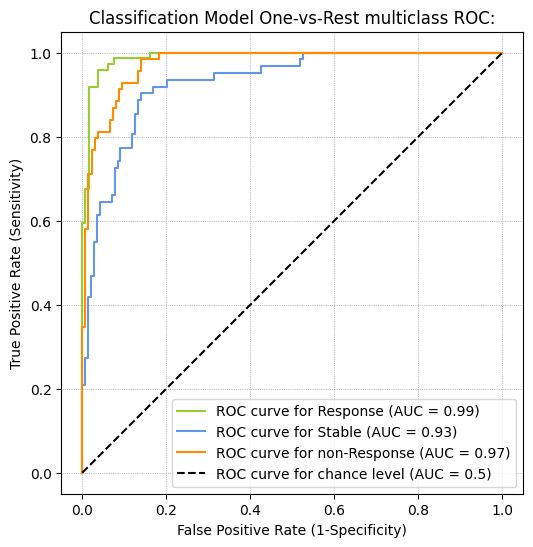

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


#target names
target_names = ['Response','Stable','non-Response']
#colors
colors = cycle(["yellowgreen", "cornflowerblue", "darkorange"])

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)",)
plt.axis("square")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(color='grey', linestyle='dotted', linewidth=0.5)
plt.title("Classification Model One-vs-Rest multiclass ROC:")
plt.legend()
plt.savefig('ROC_attention.eps', format='eps',bbox_inches='tight',dpi=800)
plt.show()

In [ ]:
np.save('fpr_att.npy',fpr)
np.save('tpr_att.npy',tpr)
np.save('roc_att.npy',roc_auc)

In [ ]:
np.save('model_attention2.npy',history.history)

               lr      loss  accuracy  val_loss  val_accuracy
295  2.398252e-06  0.317478  0.865794  0.301992      0.863415
296  1.534998e-06  0.317469  0.865794  0.301976      0.863415
297  8.635670e-07  0.317462  0.865794  0.301977      0.863415
298  3.837496e-07  0.317464  0.865794  0.301980      0.863415
299  9.596348e-08  0.317459  0.865794  0.301980      0.863415


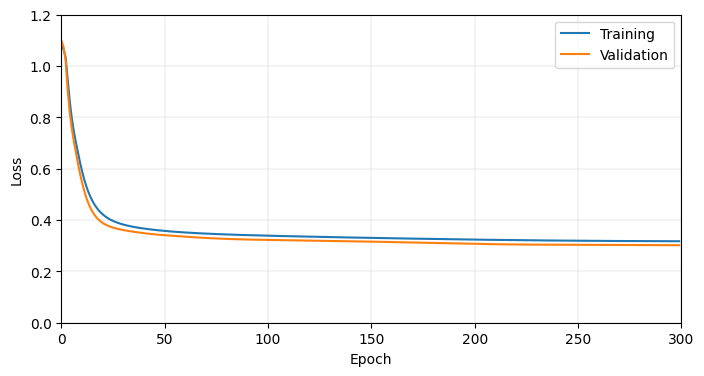

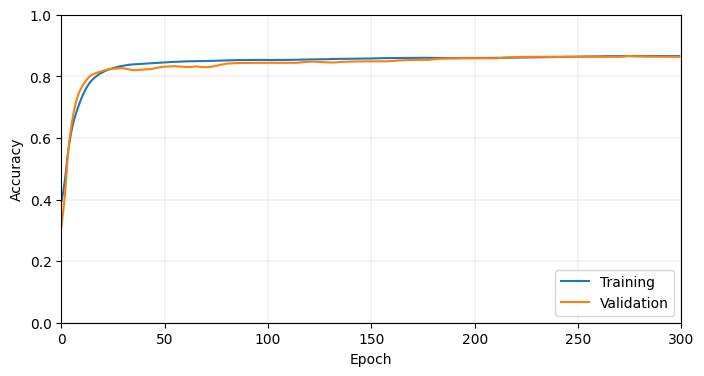

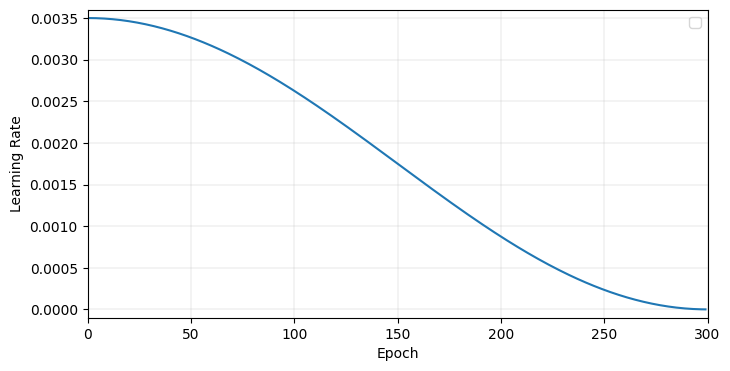

In [ ]:
df=np.load('model_attention2.npy',allow_pickle=True)
df1=pd.DataFrame({'lr': df.item()['lr'],'loss': df.item()['loss'],'accuracy': df.item()['accuracy'],'val_loss': df.item()['val_loss'],'val_accuracy': df.item()['val_accuracy']})
print(df1.tail())

plt.figure(figsize=(8,4))
ax = df1['loss'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_loss'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.grid(linewidth=0.2)
plt.ylim([0, 1.2])
plt.xlim([-0.1, 300])
plt.legend(loc='upper right')

plt.figure(figsize=(8,4))
ax = df1['accuracy'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_accuracy'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 300])
plt.legend(loc='lower right')

plt.figure(figsize=(8,4))
ax = df1['lr'].plot(label='')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.grid(linewidth=0.2)
plt.ylim([-0.0001,0.0036])
plt.xlim([-0.1, 300])
plt.legend(loc='upper right')

In [ ]:
df=np.load('model_cnn_threeclasses.npy',allow_pickle=True)
df1=pd.DataFrame({'loss_cnn': df.item()['loss'],'accuracy_cnn': df.item()['accuracy'],'val_loss_cnn': df.item()['val_loss'],'val_accuracy_cnn': df.item()['val_accuracy']})
df=np.load('model_cnn_fc_threeclasses.npy',allow_pickle=True)
df2=pd.DataFrame({'lr_cnn_fc': df.item()['lr'],'loss_cnn_fc': df.item()['loss'],'accuracy_cnn_fc': df.item()['accuracy'],'val_loss_cnn_fc': df.item()['val_loss'],'val_accuracy_cnn_fc': df.item()['val_accuracy']})
df=np.load('model_cnn_fc_augm_threeclasses.npy',allow_pickle=True)
df3=pd.DataFrame({'lr_cnn_fc_augm': df.item()['lr'],'loss_cnn_fc_augm': df.item()['loss'],'accuracy_cnn_fc_augm': df.item()['accuracy'],'val_loss_cnn_fc_augm': df.item()['val_loss'],'val_accuracy_cnn_fc_augm': df.item()['val_accuracy']})
df=np.load('model_attention2.npy',allow_pickle=True)
df4=pd.DataFrame({'lr_att': df.item()['lr'],'loss_att': df.item()['loss'],'accuracy_att': df.item()['accuracy'],'val_loss_att': df.item()['val_loss'],'val_accuracy_att': df.item()['val_accuracy']})
df5=pd.concat([df1,df2,df3,df4],axis=1)
df5.tail()

loss_cnn  accuracy_cnn  val_loss_cnn  val_accuracy_cnn     lr_cnn_fc  \
395  0.337328      0.848168      0.404794           0.82439  1.156479e-06   
396  0.337308      0.848168      0.404787           0.82439  7.402003e-07   
397  0.337311      0.848168      0.404797           0.82439  4.163682e-07   
398  0.337297      0.848168      0.404798           0.82439  1.850724e-07   
399  0.337295      0.847120      0.404795           0.82439  4.622340e-08   

     loss_cnn_fc  accuracy_cnn_fc  val_loss_cnn_fc  val_accuracy_cnn_fc  \
395     0.371170         0.839791         0.365907             0.834146   
396     0.353922         0.851309         0.365896             0.834146   
397     0.371173         0.841885         0.365904             0.834146   
398     0.364372         0.848168         0.365900             0.834146   
399     0.353986         0.858639         0.365898             0.834146   

     lr_cnn_fc_augm  loss_cnn_fc_augm  accuracy_cnn_fc_augm  \
395    1.349226e-06          0.280413              0.883797   
396    8.635670e-07          0.276981              0.879214   
397    4.857630e-07          0.274624              0.880524   
398    2.159178e-07          0.278718              0.879214   
399    5.392731e-08          0.274959              0.882488   

     val_loss_cnn_fc_augm  val_accuracy_cnn_fc_augm  lr_att  loss_att  \
395              0.322984                  0.853659     NaN       NaN   
396              0.323003                  0.853659     NaN       NaN   
397              0.322997                  0.853659     NaN       NaN   
398              0.322979                  0.853659     NaN       NaN   
399              0.322980                  0.853659     NaN       NaN   

     accuracy_att  val_loss_att  val_accuracy_att  
395           NaN           NaN               NaN  
396           NaN           NaN               NaN  
397           NaN           NaN               NaN  
398           NaN           NaN               NaN  
399           NaN           NaN               NaN

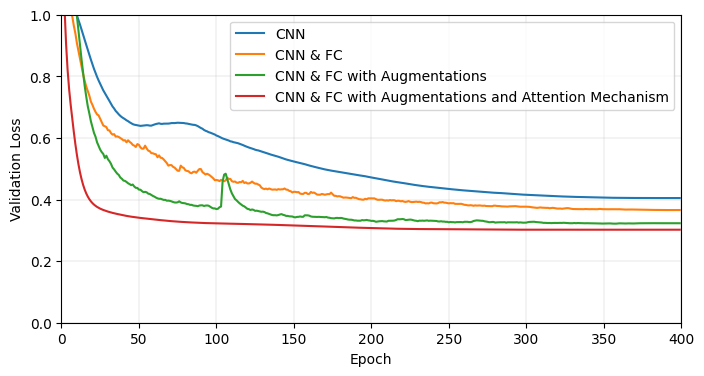

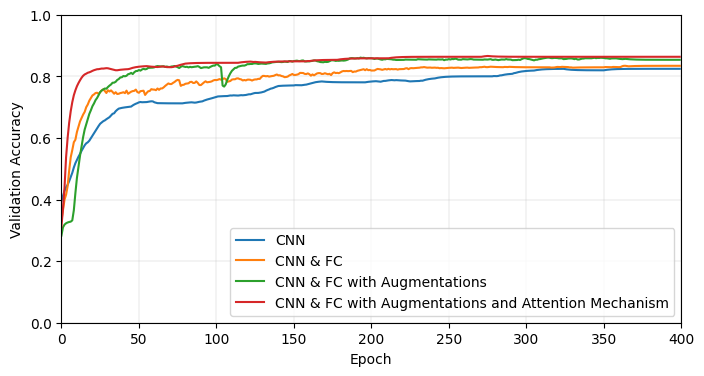

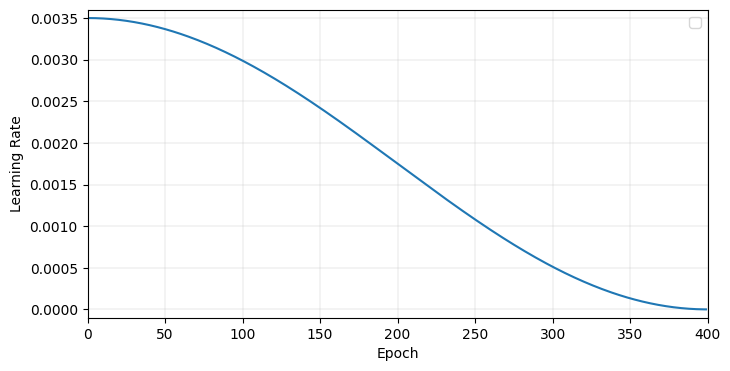

In [ ]:
plt.figure(figsize=(8,4))
ax = df5['val_loss_cnn'].ewm(span=10).mean().plot(label='CNN')
ax = df5['val_loss_cnn_fc'].ewm(span=10).mean().plot(label='CNN & FC')
ax = df5['val_loss_cnn_fc_augm'].ewm(span=10).mean().plot(label='CNN & FC with Augmentations')
ax = df5['val_loss_att'].ewm(span=10).mean().plot(label='CNN & FC with Augmentations and Attention Mechanism')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 400])
plt.legend(loc='upper right')


plt.figure(figsize=(8,4))
ax = df5['val_accuracy_cnn'].ewm(span=10).mean().plot(label='CNN')
ax = df5['val_accuracy_cnn_fc'].ewm(span=10).mean().plot(label='CNN & FC')
ax = df5['val_accuracy_cnn_fc_augm'].ewm(span=10).mean().plot(label='CNN & FC with Augmentations')
ax = df5['val_accuracy_att'].ewm(span=10).mean().plot(label='CNN & FC with Augmentations and Attention Mechanism')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 400])
plt.legend(loc='lower right')

plt.figure(figsize=(8,4))
ax = df5['lr_cnn_fc_augm'].plot(label='')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.grid(linewidth=0.2)
plt.ylim([-0.0001,0.0036])
plt.xlim([-0.1, 400])
plt.legend(loc='upper right')

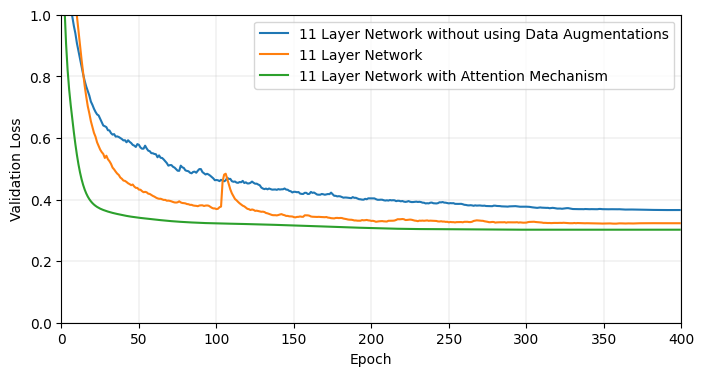

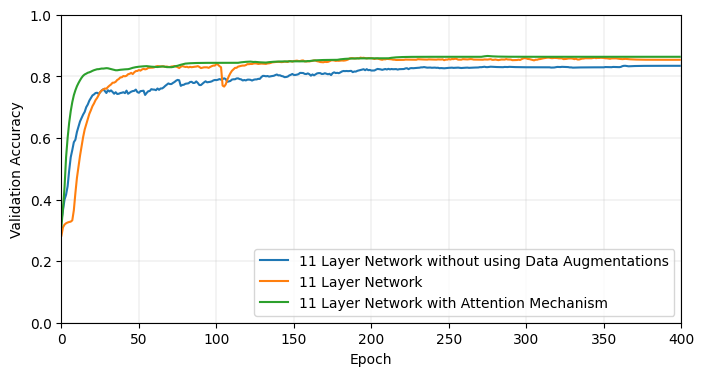

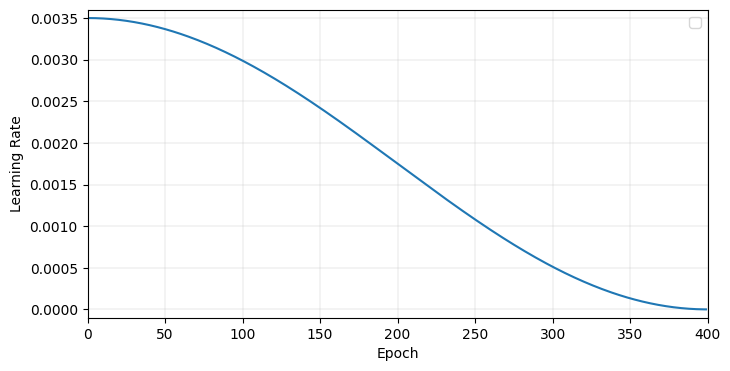

In [ ]:
plt.figure(figsize=(8,4))
ax = df5['val_loss_cnn_fc'].ewm(span=10).mean().plot(label='11 Layer Network without using Data Augmentations')
ax = df5['val_loss_cnn_fc_augm'].ewm(span=10).mean().plot(label='11 Layer Network')
ax = df5['val_loss_att'].ewm(span=10).mean().plot(label='11 Layer Network with Attention Mechanism')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 400])
plt.legend(loc='upper right')
plt.savefig('classification_loss.eps', format='eps',bbox_inches='tight',dpi=500)

plt.figure(figsize=(8,4))
ax = df5['val_accuracy_cnn_fc'].ewm(span=10).mean().plot(label='11 Layer Network without using Data Augmentations')
ax = df5['val_accuracy_cnn_fc_augm'].ewm(span=10).mean().plot(label='11 Layer Network')
ax = df5['val_accuracy_att'].ewm(span=10).mean().plot(label='11 Layer Network with Attention Mechanism')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 400])
plt.legend(loc='lower right')
plt.savefig('classification_accuracy.eps', format='eps',bbox_inches='tight',dpi=500)

plt.figure(figsize=(8,4))
ax = df5['lr_cnn_fc_augm'].plot(label='')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.grid(linewidth=0.2)
plt.ylim([-0.0001,0.0036])
plt.xlim([-0.1, 400])
plt.legend(loc='upper right')
plt.savefig('classification_lr.eps', format='eps',bbox_inches='tight',dpi=500)

# State of the art architectures
https://keras.io/api/applications/

### Xception

In [ ]:
# get the input images in the required shape
my_datagen = ImageDataGenerator(rescale = 1./255)

my_set = my_datagen.flow_from_directory('./Elastography_images/classes',
                                              target_size = (71, 71),
                                              class_mode = 'binary',
                                              batch_size=1365,shuffle=False)

with tf.device('/device:GPU:0'):
  x_tr=my_set[0][0]
  y_tr=my_set[0][1].astype(int)

print(f"We have {x_tr.shape[0]} total observations")

Found 1365 images belonging to 3 classes.
We have 1365 total observations


In [ ]:
#USED IN CASE SHUFFLE IS FALSE WHILE IMPORTING THE DATA
x, y = shuffle(x_tr, y_tr)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

print(f"Training set has total {x_train.shape[0]} observations")
print(f"Validation set has total {x_val.shape[0]} observations")
print(f"Test set has total {x_test.shape[0]} observations \n \n")

print(f"Ratio of obervations with response label to total number of observations in the validation dataset is  {sum(y_val==0)/len(y_val)}")
print(f"Ratio of obervations with stable label to total number of observations in the validation dataset is  {sum(y_val==1)/len(y_val)}")
print(f"Ratio of obervations with non-response label to total number of observations in the validation dataset is  {sum(y_val==2)/len(y_val)} \n \n")

print(f"Ratio of obervations with response label to total number of observations in the test dataset is  {sum(y_test==0)/len(y_test)}")
print(f"Ratio of obervations with stable label to total number of observations in the test dataset is  {sum(y_test==1)/len(y_test)}")
print(f"Ratio of obervations with non-response label to total number of observations in the test dataset is  {sum(y_test==2)/len(y_test)} \n")

Training set has total 955 observations
Validation set has total 205 observations
Test set has total 205 observations 
 

Ratio of obervations with response label to total number of observations in the validation dataset is  0.33170731707317075
Ratio of obervations with stable label to total number of observations in the validation dataset is  0.32682926829268294
Ratio of obervations with non-response label to total number of observations in the validation dataset is  0.34146341463414637 
 

Ratio of obervations with response label to total number of observations in the test dataset is  0.3463414634146341
Ratio of obervations with stable label to total number of observations in the test dataset is  0.3170731707317073
Ratio of obervations with non-response label to total number of observations in the test dataset is  0.33658536585365856 



In [ ]:
# np.save('x_train_71.npy', x_train)
# np.save('y_train_71.npy', y_train)
# np.save('x_val_71.npy', x_val)
# np.save('y_val_71.npy', y_val)
# np.save('x_test_71.npy', x_test)
# np.save('y_test_71.npy', y_test)

#load the saved numpy arrays
x_train=np.load('x_train_71.npy')
y_train=np.load('y_train_71.npy')
x_val=np.load('x_val_71.npy')
y_val=np.load('y_val_71.npy')
x_test=np.load('x_test_71.npy')
y_test=np.load('y_test_71.npy')

In [ ]:
print(f"Training set before augmentations: {x_train.shape[0]}")
x_train_augm,y_train_augm=apply_augmentations(x_train,y_train,size=300,horizontalflip=True,RandomCrops=True,verticalflip=True,combine=False,brightness=True,RandomRotations=True)
print(f"Training set after augmentations: {x_train_augm.shape[0]}")

Training set before augmentations: 955
(1255, 71, 71, 3)
(1255,)
(1555, 71, 71, 3)
(1555,)
(1705, 71, 71, 3)
(1705,)
(1855, 71, 71, 3)
(1855,)
(2005, 71, 71, 3)
(2005,)
Training set after augmentations: 2005


In [ ]:
#batch size
batch_size=64
#From numpy arrays to dataset
with tf.device('/device:GPU:0'):
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
  val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
  test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [ ]:
base_model = keras.applications.Xception(weights=None, include_top=False, input_shape=(71,71,3))

# # Freeze the layers of the Xception model
# for layer in base_model.layers:
#     layer.trainable = False

inputs = keras.Input(shape=(71, 71,3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_xception = keras.Model(inputs, outputs)
model_xception.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 100)               204900    
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 3)                 303       
                                                           

In [ ]:
epochs=200

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(0.001, epochs)


# Compile the model
adam=keras.optimizers.Adam(learning_rate=0.001)

def lr_scheduler(epoch, lr):
    return cosine_decay(epoch)

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

model_xception.compile(
    optimizer=adam,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# class LRTensorBoard(keras.callbacks.TensorBoard):
#     # add other arguments to __init__ if you need
#     def __init__(self, log_dir, **kwargs):
#         super().__init__(log_dir=log_dir, **kwargs)

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         logs.update({'lr': keras.backend.eval(self.model.optimizer.lr)})
#         super().on_epoch_end(epoch, logs)

# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=0, mode="min",baseline=None,restore_best_weights=True,start_from_epoch=20,)

# Train the model using a dataset
with tf.device('/device:GPU:0'):
  history = model_xception.fit(train_set, epochs=epochs,validation_data=val_set,callbacks=[lr_scheduler_callback,early_stop])

Epoch 1/200
15/15 [==============================] - 29s 188ms/step - loss: 0.7927 - accuracy: 0.6356 - val_loss: 1.0988 - val_accuracy: 0.3268 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 2s 131ms/step - loss: 0.5634 - accuracy: 0.7801 - val_loss: 1.0992 - val_accuracy: 0.3268 - lr: 9.9994e-04
Epoch 3/200
15/15 [==============================] - 2s 130ms/step - loss: 0.4722 - accuracy: 0.8188 - val_loss: 1.0994 - val_accuracy: 0.3268 - lr: 9.9975e-04
Epoch 4/200
15/15 [==============================] - 2s 130ms/step - loss: 0.4015 - accuracy: 0.8314 - val_loss: 1.1002 - val_accuracy: 0.3268 - lr: 9.9944e-04
Epoch 5/200
15/15 [==============================] - 2s 131ms/step - loss: 0.3375 - accuracy: 0.8565 - val_loss: 1.1022 - val_accuracy: 0.3268 - lr: 9.9901e-04
Epoch 6/200
15/15 [==============================] - 2s 132ms/step - loss: 0.3377 - accuracy: 0.8702 - val_loss: 1.1058 - val_accuracy: 0.3268 - lr: 9.9846e-04
Epoch 7/200
15/15 [========================

In [ ]:
loss, acc = model_xception.evaluate(test_set)  # returns loss and metrics
y_test_prob=model_xception.predict(test_set)
# fpr_CNN , tpr_CNN , thresholds = roc_curve (y_test,y_test_prob)
# auc_score_CNN=roc_auc_score(y_test,y_test_prob)

print("Loss on test set: %.2f" % loss)
print("Acc on test set: %.2f" % acc)
# print(f"AUC score is: {auc_score_CNN}")

4/4 [==============================] - 1s 33ms/step
Loss on test set: 2.00
Acc on test set: 0.81


In [ ]:
#save or load the model
# model_xception.save("model_xception")
model_xception = keras.models.load_model('model_xception')

In [ ]:
np.save('model_xception.npy',history.history)

df=np.load('model_xception.npy',allow_pickle=True)
df1=pd.DataFrame({'lr': df.item()['lr'],'loss': df.item()['loss'],'accuracy': df.item()['accuracy'],'val_loss': df.item()['val_loss'],'val_accuracy': df.item()['val_accuracy']})
print(df1.tail())

           lr      loss  accuracy  val_loss  val_accuracy
102  0.000484  0.000314       1.0  2.186726      0.804878
103  0.000476  0.000310       1.0  2.197189      0.814634
104  0.000469  0.000233       1.0  2.206202      0.814634
105  0.000461  0.000115       1.0  2.211386      0.814634
106  0.000453  0.000385       1.0  2.216904      0.814634


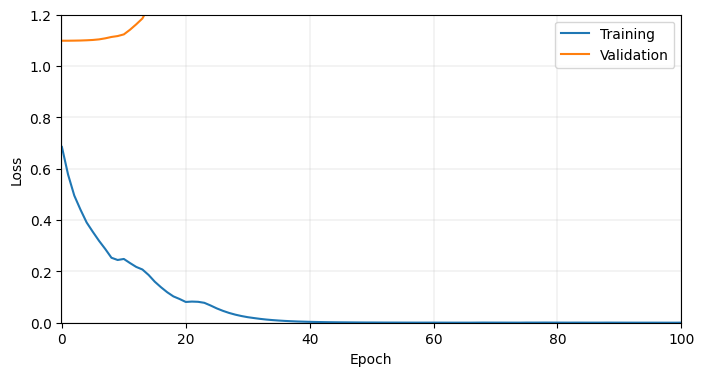

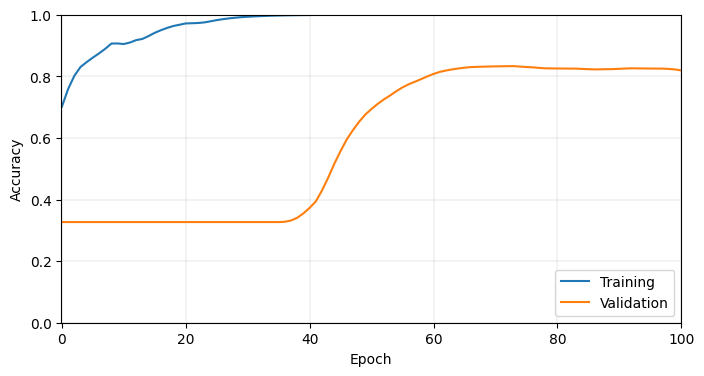

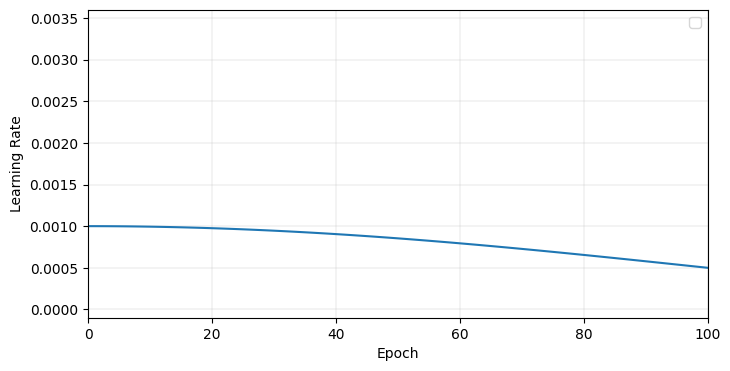

In [ ]:
plt.figure(figsize=(8,4))
ax = df1['loss'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_loss'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.grid(linewidth=0.2)
plt.ylim([0, 1.2])
plt.xlim([-0.1, 100])
plt.legend(loc='upper right')

plt.figure(figsize=(8,4))
ax = df1['accuracy'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_accuracy'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 100])
plt.legend(loc='lower right')

plt.figure(figsize=(8,4))
ax = df1['lr'].plot(label='')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.grid(linewidth=0.2)
plt.ylim([-0.0001,0.0036])
plt.xlim([-0.1, 100])
plt.legend(loc='upper right')

4/4 [==============================] - 0s 49ms/step

Probability per class for the first 5 images in the test set: 
 [[6.6362950e-06 9.9976319e-01 2.3014635e-04]
 [3.1019629e-06 9.9999428e-01 2.5689358e-06]
 [5.2167088e-08 1.0000000e+00 1.4855458e-08]
 [8.6535209e-08 9.9999988e-01 2.5857057e-08]
 [1.0000000e+00 3.3594731e-08 4.0338723e-13]] 

Predicted class for the first 5 images of the test set 
 [1 1 1 1 0]


<Figure size 640x480 with 0 Axes>

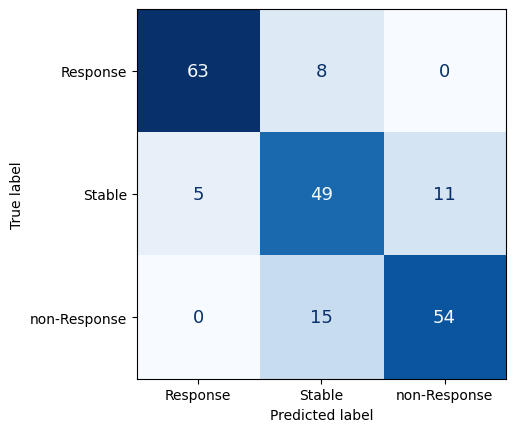

In [ ]:
y_pred=model_xception.predict(test_set)
print(f"\nProbability per class for the first 5 images in the test set: \n {y_pred[0:5]} \n")
predictions = np.argmax(y_pred, axis=-1)
print(f"Predicted class for the first 5 images of the test set \n {predictions[0:5]}")

fig = plt.figure()
cf_matrix = confusion_matrix(y_test,predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['Response','Stable','non-Response'])
cm_display.plot(colorbar=False, text_kw={'fontsize':13,'fontweight':'book','fontstyle':'normal'},cmap='Blues')
plt.savefig('conf_xception.eps', format='eps',bbox_inches='tight',dpi=600)

4/4 [==============================] - 0s 48ms/step


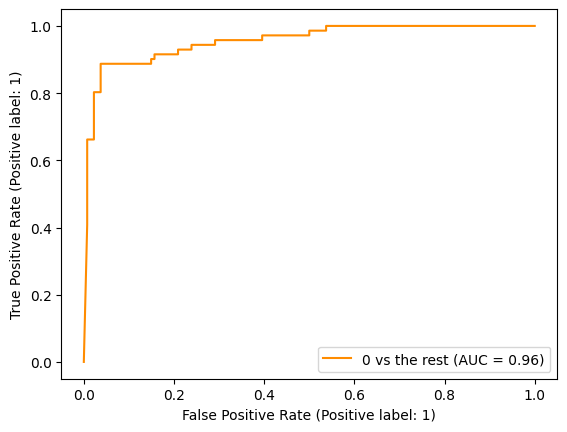

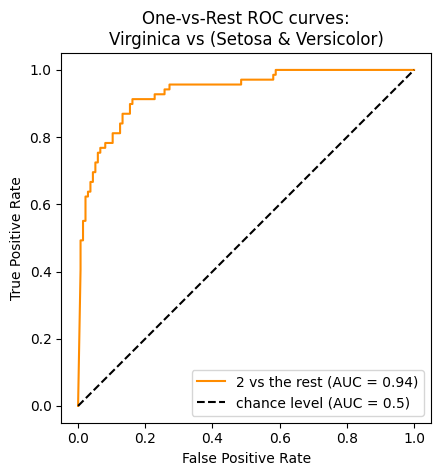

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

def plot_roc(my_class):
  label_binarizer = LabelBinarizer().fit(y_train)
  y_onehot_test = label_binarizer.transform(y_test)
  y_onehot_test.shape  # (n_samples, n_classes)

  class_of_interest = my_class
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
  class_id

  x=RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
      color="darkorange",
  )

  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
  plt.legend()
  plt.show()

y_score=model_xception.predict(test_set)
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.92
Macro-averaged One-vs-Rest ROC AUC score:
0.92


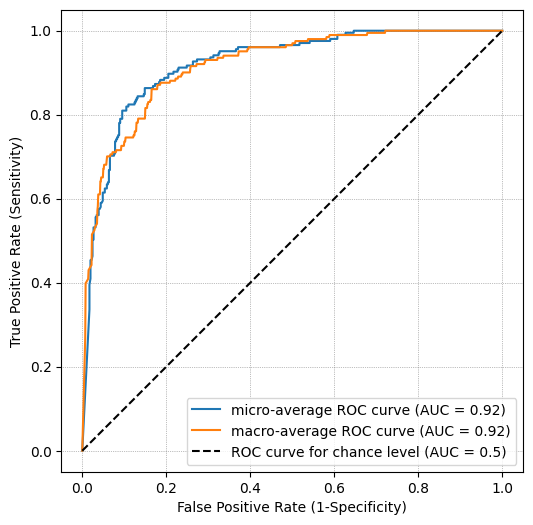

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",

)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)",)
plt.axis("square")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(color='grey', linestyle='dotted', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
np.save('fpr_xception.npy',fpr)
np.save('tpr_xception.npy',tpr)
np.save('roc_auc_xception.npy',roc_auc)

### VGG16 or VGG19

In [ ]:
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(71,71,3))

# # Freeze the layers of the Xception model
# for layer in base_model.layers:
#     layer.trainable = False

inputs = keras.Input(shape=(71, 71,3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_vgg = keras.Model(inputs, outputs)
model_vgg.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_9   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 100)               51300     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_20 (Dense)            (None, 10)                1010      
                                                           

In [ ]:
epochs=200

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(0.0001, epochs)


# Compile the model
adam=keras.optimizers.Adam(learning_rate=0.0001)

def lr_scheduler(epoch, lr):
    return cosine_decay(epoch)

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

model_vgg.compile(
    optimizer=adam,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=0, mode="min",baseline=None,restore_best_weights=True,start_from_epoch=20,)

# Train the model using a dataset
with tf.device('/device:GPU:0'):
  history = model_vgg.fit(train_set, epochs=epochs,validation_data=val_set,callbacks=[lr_scheduler_callback,early_stop])

Epoch 1/200
15/15 [==============================] - 13s 336ms/step - loss: 1.2329 - accuracy: 0.3613 - val_loss: 0.9998 - val_accuracy: 0.6976 - lr: 1.0000e-04
Epoch 2/200
15/15 [==============================] - 1s 99ms/step - loss: 0.9827 - accuracy: 0.4743 - val_loss: 0.8398 - val_accuracy: 0.6341 - lr: 9.9994e-05
Epoch 3/200
15/15 [==============================] - 1s 99ms/step - loss: 0.8893 - accuracy: 0.5613 - val_loss: 0.7149 - val_accuracy: 0.6634 - lr: 9.9975e-05
Epoch 4/200
15/15 [==============================] - 1s 99ms/step - loss: 0.8535 - accuracy: 0.5675 - val_loss: 0.7120 - val_accuracy: 0.7024 - lr: 9.9944e-05
Epoch 5/200
15/15 [==============================] - 1s 99ms/step - loss: 0.8360 - accuracy: 0.6094 - val_loss: 0.7520 - val_accuracy: 0.6780 - lr: 9.9901e-05
Epoch 6/200
15/15 [==============================] - 1s 99ms/step - loss: 0.7905 - accuracy: 0.6220 - val_loss: 0.7506 - val_accuracy: 0.6732 - lr: 9.9846e-05
Epoch 7/200
15/15 [=========================

In [ ]:
loss, acc = model_vgg.evaluate(test_set)  # returns loss and metrics
y_test_prob=model_vgg.predict(test_set)

print("Loss on test set: %.2f" % loss)
print("Acc on test set: %.2f" % acc)

4/4 [==============================] - 0s 39ms/step
Loss on test set: 0.48
Acc on test set: 0.80


In [ ]:
#save or load the model
# model_vgg.save("model_vgg")
model_vgg = keras.models.load_model('model_vgg')

In [ ]:
y_pred=model_vgg.predict(test_set)
print(f"\nProbability per class for the first 5 images in the test set: \n {y_pred[0:5]} \n")
predictions = np.argmax(y_pred, axis=-1)
print(f"Predicted class for the first 5 images of the test set \n {predictions[0:5]}")

4/4 [==============================] - 0s 40ms/step

Probability per class for the first 5 images in the test set: 
 [[9.3127593e-02 2.3436595e-01 6.7250651e-01]
 [1.8813848e-01 3.1532112e-01 4.9654040e-01]
 [1.5486382e-01 8.1162107e-01 3.3515040e-02]
 [1.4692673e-01 8.3091313e-01 2.2160165e-02]
 [1.0000000e+00 1.7795422e-09 1.3766724e-27]] 

Predicted class for the first 5 images of the test set 
 [2 2 1 1 0]


<Figure size 640x480 with 0 Axes>

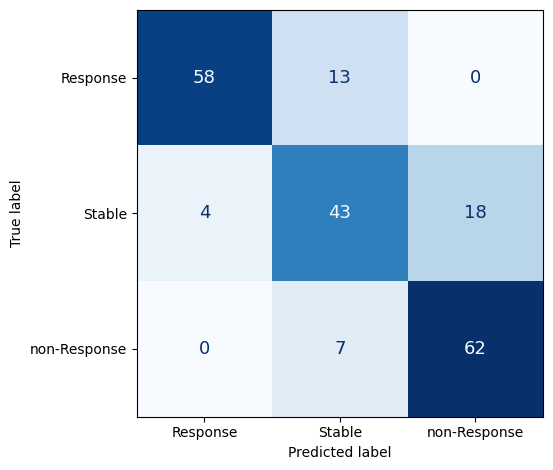

In [ ]:
fig = plt.figure()
cf_matrix = confusion_matrix(y_test,predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['Response','Stable','non-Response'])

cm_display.plot(colorbar=False, text_kw={'fontsize':13,'fontweight':'book','fontstyle':'normal'},cmap='Blues')
plt.tight_layout()
plt.savefig('conf_vgg.eps', format='eps',bbox_inches='tight',dpi=600)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

def plot_roc(my_class):
  label_binarizer = LabelBinarizer().fit(y_train)
  y_onehot_test = label_binarizer.transform(y_test)
  y_onehot_test.shape  # (n_samples, n_classes)

  class_of_interest = my_class
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
  class_id

  x=RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
      color="darkorange",
  )

  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
  plt.legend()
  plt.show()

In [ ]:
y_score=model_vgg.predict(test_set)
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

4/4 [==============================] - 0s 40ms/step


(205, 3)

In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.94


In [ ]:
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.94


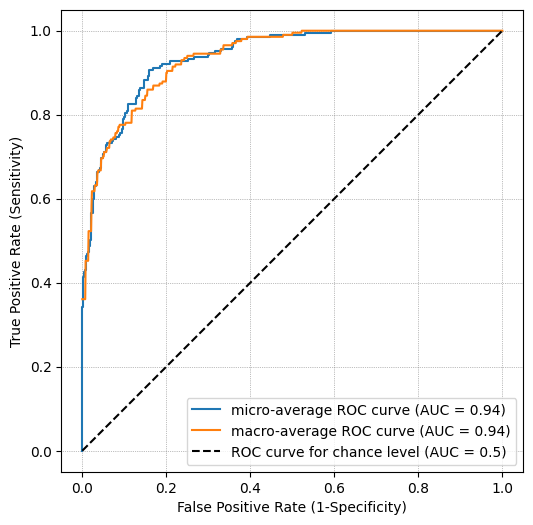

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",

)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
)


plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)",)
plt.axis("square")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(color='grey', linestyle='dotted', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
np.save('fpr_vgg.npy',fpr)
np.save('tpr_vgg.npy',tpr)
np.save('roc_vgg.npy',roc_auc)

### Inception

In [ ]:
# get the input images in the required shape
my_datagen = ImageDataGenerator(rescale = 1./255)

my_set = my_datagen.flow_from_directory('./Elastography_images/classes',
                                              target_size = (75, 75),
                                              class_mode = 'binary',
                                              batch_size=1365,shuffle=False)

with tf.device('/device:GPU:0'):
  x_tr=my_set[0][0]
  y_tr=my_set[0][1].astype(int)

print(f"We have {x_tr.shape[0]} total observations")

Found 1365 images belonging to 3 classes.
We have 1365 total observations


In [ ]:
#USED IN CASE SHUFFLE IS FALSE WHILE IMPORTING THE DATA
x, y = shuffle(x_tr, y_tr)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

print(f"Training set has total {x_train.shape[0]} observations")
print(f"Validation set has total {x_val.shape[0]} observations")
print(f"Test set has total {x_test.shape[0]} observations \n \n")

print(f"Ratio of obervations with response label to total number of observations in the validation dataset is  {sum(y_val==0)/len(y_val)}")
print(f"Ratio of obervations with stable label to total number of observations in the validation dataset is  {sum(y_val==1)/len(y_val)}")
print(f"Ratio of obervations with non-response label to total number of observations in the validation dataset is  {sum(y_val==2)/len(y_val)} \n \n")

print(f"Ratio of obervations with response label to total number of observations in the test dataset is  {sum(y_test==0)/len(y_test)}")
print(f"Ratio of obervations with stable label to total number of observations in the test dataset is  {sum(y_test==1)/len(y_test)}")
print(f"Ratio of obervations with non-response label to total number of observations in the test dataset is  {sum(y_test==2)/len(y_test)} \n")

Training set has total 955 observations
Validation set has total 205 observations
Test set has total 205 observations 
 

Ratio of obervations with response label to total number of observations in the validation dataset is  0.36097560975609755
Ratio of obervations with stable label to total number of observations in the validation dataset is  0.3121951219512195
Ratio of obervations with non-response label to total number of observations in the validation dataset is  0.32682926829268294 
 

Ratio of obervations with response label to total number of observations in the test dataset is  0.375609756097561
Ratio of obervations with stable label to total number of observations in the test dataset is  0.3121951219512195
Ratio of obervations with non-response label to total number of observations in the test dataset is  0.3121951219512195 



In [ ]:
# np.save('x_train_75.npy', x_train)
# np.save('y_train_75.npy', y_train)
# np.save('x_val_75.npy', x_val)
# np.save('y_val_75.npy', y_val)
# np.save('x_test_75.npy', x_test)
# np.save('y_test_75.npy', y_test)

#load the saved numpy arrays
x_train=np.load('x_train_75.npy')
y_train=np.load('y_train_75.npy')
x_val=np.load('x_val_75.npy')
y_val=np.load('y_val_75.npy')
x_test=np.load('x_test_75.npy')
y_test=np.load('y_test_75.npy')

In [ ]:
print(f"Training set before augmentations: {x_train.shape[0]}")
x_train_augm,y_train_augm=apply_augmentations(x_train,y_train,size=300,horizontalflip=True,RandomCrops=True,verticalflip=True,combine=False,brightness=True,RandomRotations=True)
print(f"Training set after augmentations: {x_train_augm.shape[0]}")

Training set before augmentations: 955
(1255, 75, 75, 3)
(1255,)
(1555, 75, 75, 3)
(1555,)
(1705, 75, 75, 3)
(1705,)
(1855, 75, 75, 3)
(1855,)
(2005, 75, 75, 3)
(2005,)
Training set after augmentations: 2005


In [ ]:
#batch size
batch_size=64
#From numpy arrays to dataset
with tf.device('/device:GPU:0'):
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
  val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
  test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

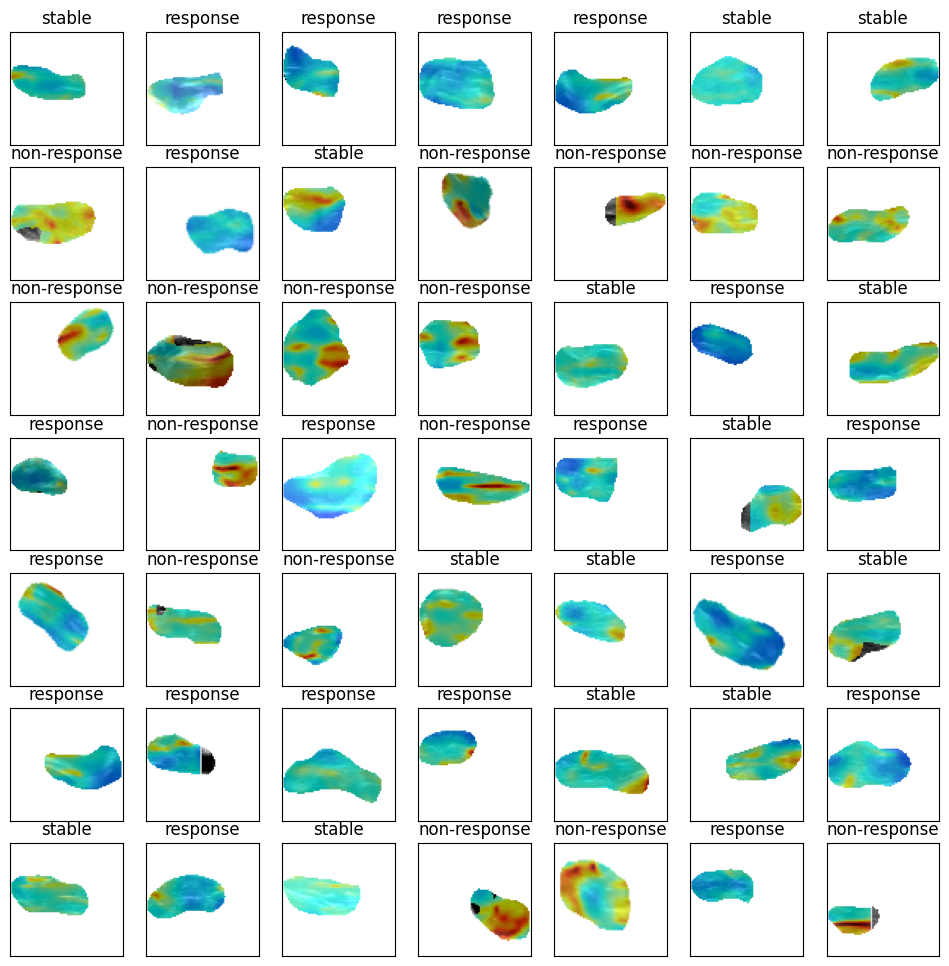

In [ ]:
#Let's see some non response images
with tf.device('/device:GPU:0'):
  j=7
  plt.figure(figsize =(12,12))

  class_names=['response','stable','non-response']

  for i in range(j**2):
      plt.subplot(j,j,i+1)
      imgplot = plt.imshow(x_train_augm[i])
      plt.title(class_names[y_train_augm[i].astype(int)])
      plt.axis("on")
      plt.xticks([]),plt.yticks([])

In [ ]:
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(75,75,3))

# # Freeze the layers of the Xception model
# for layer in base_model.layers:
#     layer.trainable = False

inputs = keras.Input(shape=(75, 75,3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_inc = keras.Model(inputs, outputs)
model_inc.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_13  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 200)               409800    
                                                                 
 dropout_17 (Dropout)        (None, 200)               0         
                                                                 
 dense_31 (Dense)            (None, 50)                10050     
                                                          

In [ ]:
epochs=200

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(0.0001, epochs)


# Compile the model
adam=keras.optimizers.Adam(learning_rate=0.0001)

def lr_scheduler(epoch, lr):
    return cosine_decay(epoch)

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

model_inc.compile(
    optimizer=adam,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0,patience=70,verbose=0, mode="max",baseline=None,restore_best_weights=True,start_from_epoch=20,)

# Train the model using a dataset
with tf.device('/device:GPU:0'):
  history = model_inc.fit(train_set, epochs=epochs,validation_data=val_set,callbacks=[lr_scheduler_callback,early_stop])

Epoch 1/200
15/15 [==============================] - 36s 161ms/step - loss: 1.2010 - accuracy: 0.3099 - val_loss: 1.3276 - val_accuracy: 0.3659 - lr: 1.0000e-04
Epoch 2/200
15/15 [==============================] - 1s 65ms/step - loss: 1.1296 - accuracy: 0.3906 - val_loss: 1.3015 - val_accuracy: 0.3317 - lr: 9.9994e-05
Epoch 3/200
15/15 [==============================] - 1s 65ms/step - loss: 1.0649 - accuracy: 0.4335 - val_loss: 1.4594 - val_accuracy: 0.3317 - lr: 9.9975e-05
Epoch 4/200
15/15 [==============================] - 1s 66ms/step - loss: 1.0328 - accuracy: 0.4806 - val_loss: 1.5796 - val_accuracy: 0.3268 - lr: 9.9944e-05
Epoch 5/200
15/15 [==============================] - 1s 65ms/step - loss: 0.9259 - accuracy: 0.5948 - val_loss: 1.2637 - val_accuracy: 0.3317 - lr: 9.9901e-05
Epoch 6/200
15/15 [==============================] - 1s 65ms/step - loss: 0.8775 - accuracy: 0.6209 - val_loss: 1.1673 - val_accuracy: 0.3512 - lr: 9.9846e-05
Epoch 7/200
15/15 [=========================

In [ ]:
loss, acc = model_inc.evaluate(test_set)  # returns loss and metrics
y_test_prob=model_inc.predict(test_set)

print("Loss on test set: %.2f" % loss)
print("Acc on test set: %.2f" % acc)

4/4 [==============================] - 1s 27ms/step
Loss on test set: 1.02
Acc on test set: 0.77


In [ ]:
#save or load the model
# model_inc.save("model_inc")
model_inc = keras.models.load_model('model_inc')

4/4 [==============================] - 3s 238ms/step

Probability per class for the first 5 images in the test set: 
 [[6.9692670e-03 9.9176097e-01 1.2697905e-03]
 [1.0705670e-02 9.8853379e-01 7.6051598e-04]
 [2.7970644e-03 9.4196517e-03 9.8778325e-01]
 [1.4377623e-02 8.5594451e-01 1.2967783e-01]
 [2.7386019e-02 5.6449562e-02 9.1616446e-01]] 

Predicted class for the first 5 images of the test set 
 [1 1 2 1 2]


<Figure size 640x480 with 0 Axes>

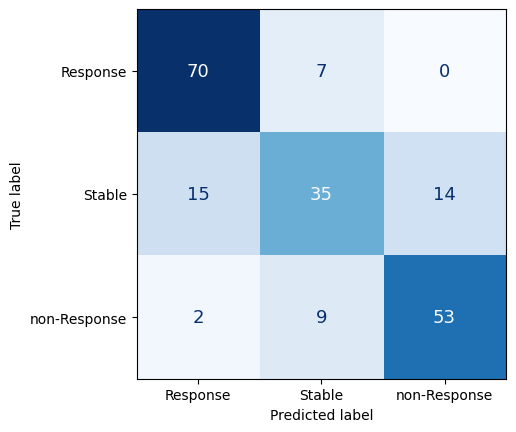

In [ ]:
y_pred=model_inc.predict(test_set)
print(f"\nProbability per class for the first 5 images in the test set: \n {y_pred[0:5]} \n")
predictions = np.argmax(y_pred, axis=-1)
print(f"Predicted class for the first 5 images of the test set \n {predictions[0:5]}")

fig = plt.figure()
cf_matrix = confusion_matrix(y_test,predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['Response','Stable','non-Response'])
cm_display.plot(colorbar=False, text_kw={'fontsize':13,'fontweight':'book','fontstyle':'normal'},cmap='Blues')
plt.savefig('conf_inc.eps', format='eps',bbox_inches='tight',dpi=600)

In [ ]:
y_score=model_inc.predict(test_set)
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

4/4 [==============================] - 0s 28ms/step


(205, 3)

In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.91


In [ ]:
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.91


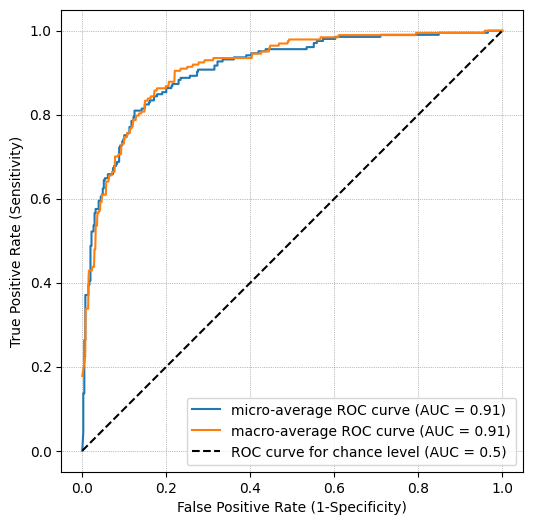

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
)


plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)",)
plt.axis("square")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(color='grey', linestyle='dotted', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
np.save('fpr_inc.npy',fpr)
np.save('tpr_inc.npy',tpr)
np.save('roc_inc.npy',roc_auc)

### ResNet

In [ ]:
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(71,71,3))

# # Freeze the layers of the Xception model
# for layer in base_model.layers:
#     layer.trainable = False

inputs = keras.Input(shape=(71, 71,3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_res = keras.Model(inputs, outputs)
model_res.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_20  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_51 (Dense)            (None, 100)               204900    
                                                                 
 dropout_31 (Dropout)        (None, 100)               0         
                                                                 
 dense_52 (Dense)            (None, 10)                1010      
                                                          

In [ ]:
epochs=200

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(0.001, epochs)


# Compile the model
adam=keras.optimizers.Adam(learning_rate=0.001)

def lr_scheduler(epoch, lr):
    return cosine_decay(epoch)

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

model_res.compile(
    optimizer=adam,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0,patience=50,verbose=0, mode="max",baseline=None,restore_best_weights=True,start_from_epoch=20,)

# Train the model using a dataset
with tf.device('/device:GPU:0'):
  history = model_res.fit(train_set, epochs=epochs,validation_data=val_set,callbacks=[lr_scheduler_callback,early_stop])

Epoch 1/200
15/15 [==============================] - 37s 187ms/step - loss: 1.0863 - accuracy: 0.5592 - val_loss: 3.8276 - val_accuracy: 0.3415 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 2s 116ms/step - loss: 0.8810 - accuracy: 0.5529 - val_loss: 10.1440 - val_accuracy: 0.3415 - lr: 9.9994e-04
Epoch 3/200
15/15 [==============================] - 2s 116ms/step - loss: 0.7835 - accuracy: 0.6084 - val_loss: 718.6558 - val_accuracy: 0.3415 - lr: 9.9975e-04
Epoch 4/200
15/15 [==============================] - 2s 116ms/step - loss: 0.7285 - accuracy: 0.6524 - val_loss: 162.4975 - val_accuracy: 0.3415 - lr: 9.9944e-04
Epoch 5/200
15/15 [==============================] - 2s 117ms/step - loss: 0.6757 - accuracy: 0.6597 - val_loss: 1.6172 - val_accuracy: 0.3317 - lr: 9.9901e-04
Epoch 6/200
15/15 [==============================] - 2s 118ms/step - loss: 0.5828 - accuracy: 0.7403 - val_loss: 1.1584 - val_accuracy: 0.3317 - lr: 9.9846e-04
Epoch 7/200
15/15 [===================

In [ ]:
loss, acc = model_res.evaluate(test_set)  # returns loss and metrics
y_test_prob=model_res.predict(test_set)

print("Loss on test set: %.2f" % loss)
print("Acc on test set: %.2f" % acc)


4/4 [==============================] - 1s 27ms/step
Loss on test set: 2.17
Acc on test set: 0.81


In [ ]:
#save or load the model
# model_res.save("model_res")
model_res = keras.models.load_model('model_res')

4/4 [==============================] - 1s 42ms/step

Probability per class for the first 5 images in the test set: 
 [[1.0213097e-10 9.9999940e-01 6.0269753e-07]
 [6.4930062e-12 1.3263493e-03 9.9867368e-01]
 [5.7929470e-11 9.9999964e-01 4.0348451e-07]
 [2.1976993e-08 9.9999285e-01 7.1969339e-06]
 [9.9999917e-01 8.3827439e-07 3.7877815e-19]] 

Predicted class for the first 5 images of the test set 
 [1 2 1 1 0]


<Figure size 640x480 with 0 Axes>

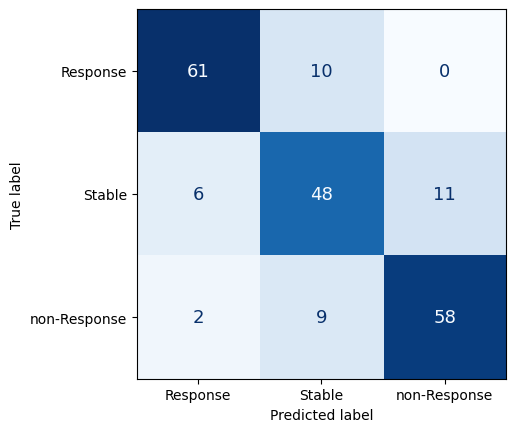

In [ ]:
y_pred=model_res.predict(test_set)
print(f"\nProbability per class for the first 5 images in the test set: \n {y_pred[0:5]} \n")
predictions = np.argmax(y_pred, axis=-1)
print(f"Predicted class for the first 5 images of the test set \n {predictions[0:5]}")

fig = plt.figure()
cf_matrix = confusion_matrix(y_test,predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['Response','Stable','non-Response'])
cm_display.plot(colorbar=False, text_kw={'fontsize':13,'fontweight':'book','fontstyle':'normal'},cmap='Blues')
plt.savefig('conf_res.eps', format='eps',bbox_inches='tight',dpi=600)

In [ ]:
y_score=model_res.predict(test_set)
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

4/4 [==============================] - 0s 44ms/step
Micro-averaged One-vs-Rest ROC AUC score:
0.92


In [ ]:
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.92


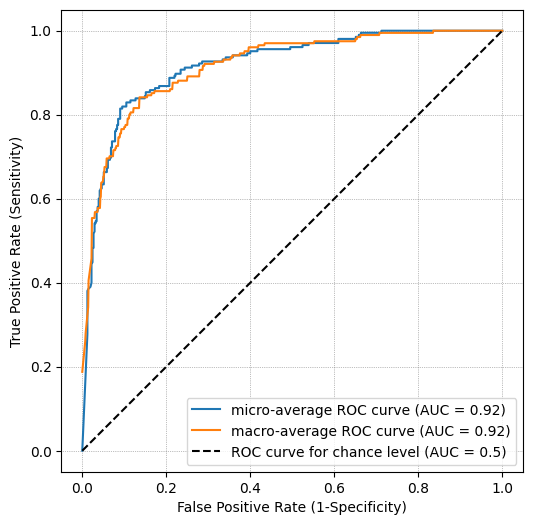

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
)


plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)",)
plt.axis("square")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(color='grey', linestyle='dotted', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
np.save('fpr_res.npy',fpr)
np.save('tpr_res.npy',tpr)
np.save('roc_res.npy',roc_auc)

### Compare architectures with Macro
Obtaining the macro-average requires computing the metric independently for each class and then taking the average over them, hence treating all classes equally a priori

In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging.

In [ ]:
# fpr
fpr_att=np.load('fpr_att.npy',allow_pickle=True)
fpr_xception=np.load('fpr_xception.npy',allow_pickle=True)
fpr_vgg=np.load('fpr_vgg.npy',allow_pickle=True)
fpr_inc=np.load('fpr_inc.npy',allow_pickle=True)
fpr_res=np.load('fpr_res.npy',allow_pickle=True)
fpr_cnn=np.load('fpr_cnn.npy',allow_pickle=True)
fpr_combined=np.load('fpr_combined.npy',allow_pickle=True)

In [ ]:
# tpr
tpr_att=np.load('tpr_att.npy',allow_pickle=True)
tpr_xception=np.load('tpr_xception.npy',allow_pickle=True)
tpr_vgg=np.load('tpr_vgg.npy',allow_pickle=True)
tpr_inc=np.load('tpr_inc.npy',allow_pickle=True)
tpr_res=np.load('tpr_res.npy',allow_pickle=True)
tpr_cnn=np.load('tpr_cnn.npy',allow_pickle=True)
tpr_combined=np.load('tpr_combined.npy',allow_pickle=True)

In [ ]:
# tpr
roc_att=np.load('roc_att.npy',allow_pickle=True)
roc_xception=np.load('roc_auc_xception.npy',allow_pickle=True)
roc_vgg=np.load('roc_vgg.npy',allow_pickle=True)
roc_inc=np.load('roc_inc.npy',allow_pickle=True)
roc_res=np.load('roc_res.npy',allow_pickle=True)
roc_cnn=np.load('roc_cnn.npy',allow_pickle=True)
roc_combined=np.load('roc_combined.npy',allow_pickle=True)

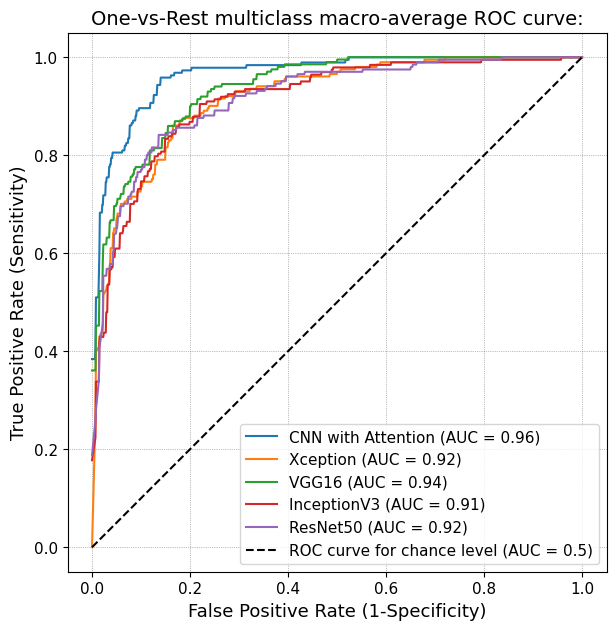

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

plt.plot(
    fpr_att.item()['macro'],
    tpr_att.item()['macro'],
    label=f"CNN with Attention (AUC = {roc_att.item()['macro']:.2f})",)

plt.plot(
    fpr_xception.item()['macro'],
    tpr_xception.item()['macro'],
    label=f"Xception (AUC = {roc_xception.item()['macro']:.2f})",)

plt.plot(
    fpr_vgg.item()['macro'],
    tpr_vgg.item()['macro'],
    label=f"VGG16 (AUC = {roc_vgg.item()['macro']:.2f})",)

plt.plot(
    fpr_inc.item()['macro'],
    tpr_inc.item()['macro'],
    label=f"InceptionV3 (AUC = {roc_inc.item()['macro']:.2f})",)

plt.plot(
    fpr_res.item()['macro'],
    tpr_res.item()['macro'],
    label=f"ResNet50 (AUC = {roc_res.item()['macro']:.2f})",)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)",)
plt.axis("square")
plt.xlabel("False Positive Rate (1-Specificity)",fontsize=13)
plt.ylabel("True Positive Rate (Sensitivity)",fontsize=13)
plt.grid(color='grey', linestyle='dotted', linewidth=0.5)
plt.title("One-vs-Rest multiclass macro-average ROC curve:",fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.savefig('macro_all_models.eps', format='eps',bbox_inches='tight',dpi=800)
plt.show()

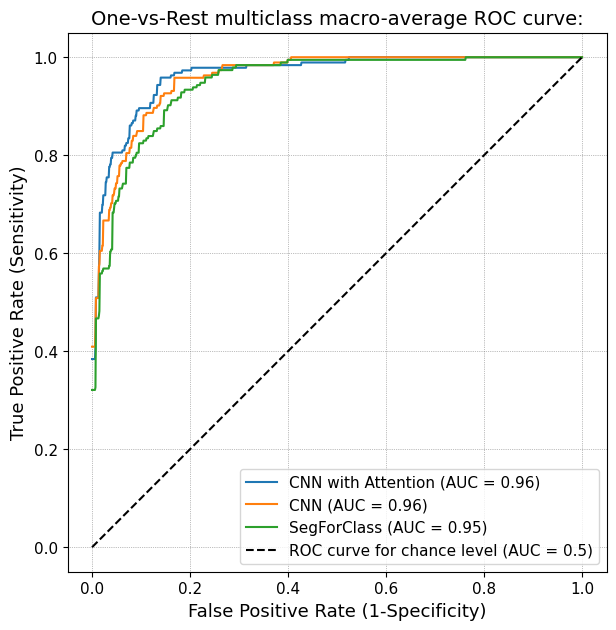

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

plt.plot(
    fpr_att.item()['macro'],
    tpr_att.item()['macro'],
    label=f"CNN with Attention (AUC = {roc_att.item()['macro']:.2f})",)

plt.plot(
    fpr_cnn.item()['macro'],
    tpr_cnn.item()['macro'],
    label=f"CNN (AUC = {roc_cnn.item()['macro']:.2f})",)

plt.plot(
    fpr_combined.item()['macro'],
    tpr_combined.item()['macro'],
    label=f"SegForClass (AUC = {roc_combined.item()['macro']:.2f})",)


plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)",)
plt.axis("square")
plt.xlabel("False Positive Rate (1-Specificity)",fontsize=13)
plt.ylabel("True Positive Rate (Sensitivity)",fontsize=13)
plt.grid(color='grey', linestyle='dotted', linewidth=0.5)
plt.title("One-vs-Rest multiclass macro-average ROC curve:",fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.savefig('macro_three_models.eps', format='eps',bbox_inches='tight',dpi=800)
plt.show()

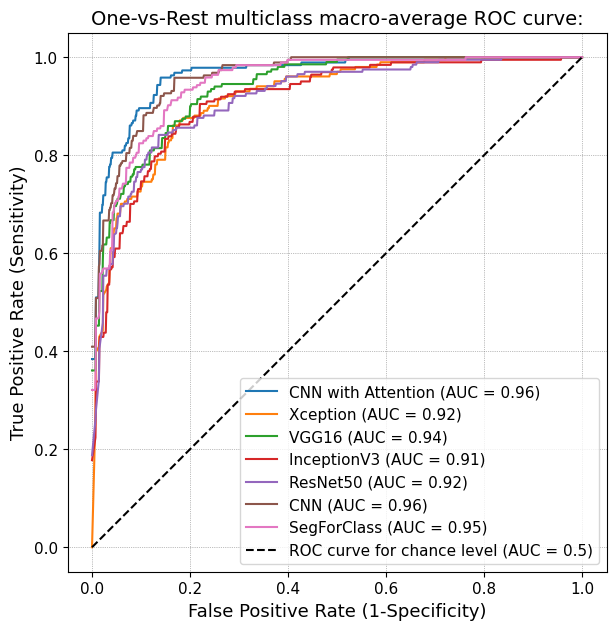

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

plt.plot(
    fpr_att.item()['macro'],
    tpr_att.item()['macro'],
    label=f"CNN with Attention (AUC = {roc_att.item()['macro']:.2f})",)

plt.plot(
    fpr_xception.item()['macro'],
    tpr_xception.item()['macro'],
    label=f"Xception (AUC = {roc_xception.item()['macro']:.2f})",)

plt.plot(
    fpr_vgg.item()['macro'],
    tpr_vgg.item()['macro'],
    label=f"VGG16 (AUC = {roc_vgg.item()['macro']:.2f})",)

plt.plot(
    fpr_inc.item()['macro'],
    tpr_inc.item()['macro'],
    label=f"InceptionV3 (AUC = {roc_inc.item()['macro']:.2f})",)

plt.plot(
    fpr_res.item()['macro'],
    tpr_res.item()['macro'],
    label=f"ResNet50 (AUC = {roc_res.item()['macro']:.2f})",)

plt.plot(
    fpr_cnn.item()['macro'],
    tpr_cnn.item()['macro'],
    label=f"CNN (AUC = {roc_cnn.item()['macro']:.2f})",)

plt.plot(
    fpr_combined.item()['macro'],
    tpr_combined.item()['macro'],
    label=f"SegForClass (AUC = {roc_combined.item()['macro']:.2f})",)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)",)
plt.axis("square")
plt.xlabel("False Positive Rate (1-Specificity)",fontsize=13)
plt.ylabel("True Positive Rate (Sensitivity)",fontsize=13)
plt.grid(color='grey', linestyle='dotted', linewidth=0.5)
plt.title("One-vs-Rest multiclass macro-average ROC curve:",fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.savefig('macro_all.eps', format='eps',bbox_inches='tight',dpi=800)
plt.show()